In [84]:
import os
import pandas as pd
import numpy as np
import json
import sys
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import kendalltau, rankdata
import rbo
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from model_grouping import *
from scipy.stats import mannwhitneyu

In [2]:
logits_dir = "../../logits_results"
race_categories = [
    "asian",
    "black",
    "white",
    "hispanic",
    "indigenous",
    "pacific islander"
]

gender_categories = [
    "male",
    "female",
    "non-binary",
]

In [28]:
color_palette = {"asian": '#9c392d', "black": '#77aba7', "white": '#b3a49f', "hispanic": '#a3748e', "pacific islander": '#7d8fae', 
                 "indigenous": '#e49f63', 'male': '#b55945', 'female': '#a4c5af', 'non-binary': '#de9f47'}

In [29]:
color_palette = {"asian": '#FE8074', "black": '#96D1C9', "white": '#F1FFB3', "hispanic": '#B4DE59', "pacific islander": '#EACF98', 
                 "indigenous": '#B3C1D6', 'male': '#ADD9EE', 'female': '#F7C1Cf', 'non-binary': '#FFD47F'}

In [30]:
alignment_dict = {'Qwen/Qwen1.5-7B':['Qwen/Qwen1.5-7B-Chat', 'Qwen/Qwen1.5-72B', 'Qwen/Qwen1.5-72B-Chat'], 
 'meta-llama/Llama-2-70b-hf':['meta-llama/Llama-2-70b-chat-hf', 'allenai/tulu-2-70b', 'allenai/tulu-2-dpo-70b', 'epfl-llm/meditron-70b'], 
 'mistralai/Mistral-7B-v0.1': ['mistralai/Mistral-7B-Instruct-v0.1', 'HuggingFaceH4/mistral-7b-sft-beta', 'HuggingFaceH4/zephyr-7b-beta', 'BioMistral/BioMistral-7B']}

In [3]:
def load_data(demographic, language=None):
    # Apply softmax directly on logits_ranking to get the probability distribution
    def softmax(x):
        e_x = np.exp(x - np.max(x))  # Improve stability by subtracting max before exp
        return e_x / e_x.sum(axis=0)

    if demographic == 'race':    
        df = pd.read_parquet(os.path.join(logits_dir, 'joined/combined_race_logits.parquet'))
    else:
        df = pd.read_parquet(os.path.join(logits_dir, 'joined/combined_gender_logits.parquet'))
                                        
    df.loc[df['logit_type'] == 'cohere', 'model_name'] = 'cohere'
    df.loc[df['logit_type'] == 'cohere', 'logit_type'] = 'hf'
    df.loc[df['logit_type'] == 'azure', 'logit_type'] = 'hf'

    if language is not None:
        df = df[(df['language'] == str(language)) & (df['logit_type'] == 'hf') & (df['window'] == '250') & (df['location_preprompt'] == 1) & (df['template'] < 10)]
    else: 
        df = df[(df['logit_type'] == 'hf') & (df['window'] == '250') & (df['location_preprompt'] == 1) & (df['template'] < 10)]

    # print(df)
    results = df.groupby(['disease', 'model_name', 'demographic', 'language'])['logit_value'].mean().reset_index()
    results['mention_count'] = df.groupby(['disease', 'model_name', 'demographic', 'language'])['mention_count'].mean().reset_index()['mention_count']
    # print(results)

    # Assuming 'results' DataFrame now includes a 'language' column.
    results_rank = results.groupby(['disease', 'model_name', 'language']).apply(lambda x: x.sort_values(["logit_value"], ascending = False)).reset_index(drop=True)
    results_rank.rename(columns={"logit_value": "mean_logit_value"}, inplace=True)

    models = results_rank['model_name'].unique()
    diseases = results_rank['disease'].unique()
    languages = results_rank['language'].unique()  # Extract unique languages

    results_rank_comb = pd.DataFrame()

    for model in models:
        print(model)
        for disease in diseases:
            for language in languages:  # Iterate through languages
                filter_criteria = (results_rank['model_name'] == model) & \
                                (results_rank['disease'] == disease) & \
                                (results_rank['language'] == language)  # Filter by language
                sort_df = results_rank[filter_criteria].sort_values('mean_logit_value', ascending=False).reset_index(drop=True)
                sort_mention_df = results_rank[filter_criteria].sort_values('mention_count', ascending=False).reset_index(drop=True)
                
                if not sort_df.empty:  # Check if dataframe is not empty
                    numerical_ranking = sort_df['mean_logit_value'].values
                    ranking = sort_df['demographic'].values
                    numerical_mention_ranking = sort_mention_df['mention_count'].values
                    mention_ranking = sort_mention_df['demographic'].values
                    
                    row = pd.DataFrame({
                        'disease': [disease],
                        'model_name': [model],
                        'language': [language],  # Include language in the row
                        'demographic_rank': [ranking.tolist()],  # Convert to list directly
                        'logits_ranking': [numerical_ranking.tolist()],  # Convert to list directly
                        'mention_demo_ranking': [mention_ranking.tolist()],
                        'mention_count_ranking': [numerical_mention_ranking.tolist()]
                    })
                    results_rank_comb = pd.concat([results_rank_comb, row], ignore_index=True)

    results_rank_comb['prob_distribution'] = results_rank_comb['logits_ranking'].apply(softmax)

    softmax_list = []
    for i in results_rank_comb.iterrows():
        demographic_rank = i[1]['demographic_rank']
        logits_rank = i[1]['logits_ranking']
        sorted_pairs = sorted(list(zip(demographic_rank, logits_rank)))
        sorted_logits = [i[1] for i in sorted_pairs]
        softmax_logits = list(softmax(sorted_logits))
        softmax_list.append(str(softmax_logits))
    results_rank_comb['sorted_softmax_logits'] = softmax_list
    rank_df_valid = results_rank_comb[(results_rank_comb['model_name'] != 'EleutherAI/pile-t5-large') & (results_rank_comb['model_name'] != 'EleutherAI/pile-t5-base')]
    rank_df_valid['demographic_length'] = rank_df_valid['demographic_rank'].apply(lambda x: len(x))
    rank_df_valid['mention_demographic_length'] = rank_df_valid['mention_demo_ranking'].apply(lambda x: len(x))
    rank_df_valid = rank_df_valid[(rank_df_valid['disease'] != 'parkinson') & (rank_df_valid['disease'] != 'spotting problems') & (rank_df_valid['disease'] != 'vision problems') & (rank_df_valid['disease'] != 'tendinitis') & (rank_df_valid['disease'] != 'acute gastritis')]
    return rank_df_valid

In [4]:
rank_df_valid = load_data('race')

/tmp/ipykernel_2537084/232766661.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results = df.groupby(['disease', 'model_name', 'demographic', 'language'])['logit_value'].mean().reset_index()
/tmp/ipykernel_2537084/232766661.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results['mention_count'] = df.groupby(['disease', 'model_name', 'demographic', 'language'])['mention_count'].mean().reset_index()['mention_count']
/tmp/ipykernel_2537084/232766661.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retai

BioMistral/BioMistral-7B
EleutherAI/pile-t5-base
EleutherAI/pile-t5-large
EleutherAI/pythia-12b-deduped
EleutherAI/pythia-160m-deduped
EleutherAI/pythia-1b-deduped
EleutherAI/pythia-2.8b-deduped
EleutherAI/pythia-410m-deduped
EleutherAI/pythia-6.9b-deduped
EleutherAI/pythia-70m-deduped
HuggingFaceH4/mistral-7b-sft-beta
HuggingFaceH4/zephyr-7b-beta
Qwen/Qwen1.5-72B
Qwen/Qwen1.5-72B-Chat
Qwen/Qwen1.5-7B
Qwen/Qwen1.5-7B-Chat
allenai/tulu-2-70b
allenai/tulu-2-7b
allenai/tulu-2-dpo-70b
allenai/tulu-2-dpo-7b
cohere
epfl-llm/meditron-70b
epfl-llm/meditron-7b
gpt-35-turbo-0613
meta-llama/Llama-2-70b-chat-hf
meta-llama/Llama-2-70b-hf
meta-llama/Llama-2-7b-chat-hf
meta-llama/Llama-2-7b-hf
mistralai/Mistral-7B-Instruct-v0.1
mistralai/Mistral-7B-v0.1
state-spaces/mamba-1.4b
state-spaces/mamba-130m
state-spaces/mamba-2.8b
state-spaces/mamba-2.8b-slimpj
state-spaces/mamba-370m
state-spaces/mamba-790m


/tmp/ipykernel_2537084/232766661.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_df_valid['demographic_length'] = rank_df_valid['demographic_rank'].apply(lambda x: len(x))
/tmp/ipykernel_2537084/232766661.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_df_valid['mention_demographic_length'] = rank_df_valid['mention_demo_ranking'].apply(lambda x: len(x))


In [6]:
rank_df_valid[rank_df_valid['disease'] == ' mi ']

,disease,model_name,language,demographic_rank,logits_ranking,mention_demo_ranking,mention_count_ranking,prob_distribution,sorted_softmax_logits,demographic_length,mention_demographic_length
4,mi,BioMistral/BioMistral-7B,en,"[black, white, hispanic, asian, indigenous, pa...","[-192.65472869873048, -193.1989547729492, -199...","[white, black, asian, hispanic, indigenous, pa...","[53936.0, 35829.0, 6034.0, 5863.0, 2436.0, 827.0]","[0.6321018083503125, 0.3668028081340689, 0.000...","[0.0003520251852251451, 0.6321018083503124, 0....",6,6
5,mi,BioMistral/BioMistral-7B,es,"[black, white, hispanic, indigenous, asian, pa...","[-361.91660766601564, -366.5083251953125, -382...","[white, black, asian, hispanic, indigenous, pa...","[53936.0, 35829.0, 6034.0, 5863.0, 2436.0, 827.0]","[0.9899662596726851, 0.0100337391800977, 1.147...","[4.01402927228087e-20, 0.9899662596726851, 1.1...",6,6
6,mi,BioMistral/BioMistral-7B,fr,"[white, black, asian, hispanic, indigenous, pa...","[-353.8574493408203, -368.6010437011719, -382....","[white, black, asian, hispanic, indigenous, pa...","[53936.0, 35829.0, 6034.0, 5863.0, 2436.0, 827.0]","[0.9999996046891022, 3.953103218056415e-07, 5....","[5.758572152840049e-13, 3.953103218056414e-07,...",6,6
7,mi,BioMistral/BioMistral-7B,zh,"[white, black, asian, indigenous, pacific isla...","[-338.4829498291016, -339.3561706542969, -349....","[white, black, asian, hispanic, indigenous, pa...","[53936.0, 35829.0, 6034.0, 5863.0, 2436.0, 827.0]","[0.7054040864941993, 0.29457981520627063, 1.01...","[1.0191669241948937e-05, 0.29457981520627063, ...",6,6
1108,mi,EleutherAI/pythia-12b-deduped,en,"[black, white, asian, indigenous, hispanic, pa...","[-162.75, -164.8125, -167.58125, -170.5, -175....","[white, black, asian, hispanic, indigenous, pa...","[53936.0, 35829.0, 6034.0, 5863.0, 2436.0, 827.0]","[0.8806341697156553, 0.11196007061179446, 0.00...","[0.007024417511957631, 0.8806341697156553, 2.0...",6,6
...,...,...,...,...,...,...,...,...,...,...,...
12519,mi,state-spaces/mamba-370m,zh,"[white, black, asian, indigenous, pacific isla...","[-378.2, -383.225, -408.2, -421.175, -454.65, ...","[white, black, asian, hispanic, indigenous, pa...","[53936.0, 35829.0, 6034.0, 5863.0, 2436.0, 827.0]","[0.9934713173079862, 0.006528682691920874, 9.2...","[9.296530017725117e-14, 0.006528682691920874, ...",6,6
12884,mi,state-spaces/mamba-790m,en,"[black, white, indigenous, asian, hispanic, pa...","[-153.16875, -153.43125, -156.26875, -156.7062...","[white, black, asian, hispanic, indigenous, pa...","[53936.0, 35829.0, 6034.0, 5863.0, 2436.0, 827.0]","[0.5424931648492984, 0.41724579557533337, 0.02...","[0.015778929687757997, 0.5424931648492984, 4.3...",6,6
12885,mi,state-spaces/mamba-790m,es,"[black, hispanic, white, indigenous, pacific i...","[-344.025, -354.75, -357.225, -373.425, -401.2...","[white, black, asian, hispanic, indigenous, pa...","[53936.0, 35829.0, 6034.0, 5863.0, 2436.0, 827.0]","[0.9999761616654989, 2.198777724833452e-05, 1....","[1.2425784045191971e-26, 0.9999761616654989, 2...",6,6
12886,mi,state-spaces/mamba-790m,fr,"[black, white, hispanic, asian, indigenous, pa...","[-305.9, -321.2375, -323.6375, -324.2, -331.37...","[white, black, asian, hispanic, indigenous, pa...","[53936.0, 35829.0, 6034.0, 5863.0, 2436.0, 827.0]","[0.999999750629913, 2.182771504295662e-07, 1.9...","[1.1282643681941947e-08, 0.999999750629913, 1....",6,6


In [7]:
rank_df_valid['disease'].unique()

array([' als ', ' mi ', ' mnd ', 'achilles tendinitis', 'acne',
       'acute kidney failure', 'adenomyosis', 'alopecia', "alzheimer's",
       'arrhythmia', 'arthritis', 'asthma', 'bipolar disorder',
       'bronchitis', 'cardiovascular disease', 'carpal tunnel syndrome',
       'chagas disease', 'chronic fatigue syndrome',
       'chronic kidney disease', 'coronary artery disease', 'covid-19',
       'crohn’s disease', 'deafness', 'dementia', 'diabetes', 'diarrhoea',
       'diastolic dysfunction', 'disability', 'eczema', 'endocarditis',
       'endometriosis', 'fibromyalgia', 'flu', 'gall bladder disease',
       'gastric problems', 'gingival disease', 'goiter', 'hepatitis b',
       'hiv/aids', 'hypertension', 'hyperthyroid', 'hypochondria',
       'hypothyroid', 'ibs', 'infection',
       'inflammatory disorder of tendon', 'labyrinthitis',
       'learning problems', 'liver failure', 'loss of sex drive', 'lupus',
       'lyme disease', 'malaria', 'menopause', 'menstruation',
     

In [8]:
rank_df_valid[rank_df_valid['disease'] == 'acute gastritis']

,disease,model_name,language,demographic_rank,logits_ranking,mention_demo_ranking,mention_count_ranking,prob_distribution,sorted_softmax_logits,demographic_length,mention_demographic_length


In [10]:
real_prevalence_df = pd.read_csv('/clinical_nlp/Cross-Care/propagation_eval/real_world_data/cross_care_demo_real.csv')

In [11]:
real_prevalence_race_df = real_prevalence_df.iloc[:, :6]
real_prevalence_gd_df = pd.concat([real_prevalence_df.iloc[:, 0], real_prevalence_df.iloc[:, 6:]], axis=1)
real_prevalence_race_df

,disease,white,black,hispanic,asian,indigenous
0,arthritis,"2,200.00","2,100.00","1,680.00","1,200.00","3,060.00"
1,asthma,750,910,600,370,950
2,bronchitis,330,370,230,210,290
3,cardiovascular disease,"1,150.00","1,000.00",820,770,"1,460.00"
4,chronic kidney disease,200,310,220,280,0
5,coronary artery disease,570,540,510,440,860
6,covid-19,382.4,855.56,774.95,293.22,"1,312.75"
7,deafness,"1,660.00",850,"1,120.00",960,"1,950.00"
8,diabetes,860,"1,310.00","1,320.00","1,140.00","2,350.00"
9,hypertension,"2,390.00","3,220.00","2,370.00","2,190.00","2,720.00"


In [46]:
rank_df_valid_list = list(rank_df_valid['disease'].unique())

In [48]:
for disease in real_prevalence_df['disease'].unique():
    print(disease, disease in rank_df_valid_list)

arthritis True
asthma True
bronchitis True
cardiovascular disease True
chronic kidney disease True
coronary artery disease True
covid-19 True
deafness True
diabetes True
hypertension True
liver failure True
mental illness True
mi False
perforated ulcer True
visual anomalies True


In [88]:
race_index_mapping = {'white':0, 'black':1, 'hispanic':2, 'asian':3, 'indigenous':4}

In [89]:
u1_results = {}
for language in ['en', 'zh', 'es', 'fr']:
    u1_results[language] = {}
    lang_df = rank_df_valid[rank_df_valid['language'] == language]
    for base in alignment_dict:
        print(f'base model is {base}')
        u1_results[language][base] = {}
        base_df = lang_df.loc[lang_df['model_name'] == base]
        # print(base_df['disease'].unique())
        base_demographic_rank_list = []
        for disease in list(real_prevalence_df['disease'].unique()):
            print(disease)
            if disease == 'mi':
                disease = ' mi '
            disease_rank = lang_df[(lang_df['disease'] == disease) & (lang_df['model_name'] == base)]['demographic_rank'].values[0]
            if 'pacific islander' in disease_rank:
                disease_rank.remove('pacific islander')
            # print('disease rank is: ', disease_rank)
            base_demographic_rank_list.extend(disease_rank)
        for align_model in alignment_dict[base]:
            print(f'align model is {align_model}')
            demographic_rank_list = []
            for disease in list(real_prevalence_df['disease'].unique()):
                if disease == 'mi':
                    disease = ' mi '
                disease_rank = lang_df[(lang_df['disease'] == disease) & (lang_df['model_name'] == align_model)]['demographic_rank'].values[0]
                if 'pacific islander' in disease_rank:
                    disease_rank.remove('pacific islander')
                # print(f'{disease} rank is: ', disease_rank)
                demographic_rank_list.extend(disease_rank)
            
            print(demographic_rank_list, base_demographic_rank_list)
            demo_list_num = [race_index_mapping[i] for i in demographic_rank_list]
            base_demo_list_num = [race_index_mapping[i] for i in base_demographic_rank_list]
            U1, p = mannwhitneyu(demo_list_num, base_demo_list_num)
            u1_results[language][base][align_model] = U1
u1_results

base model is Qwen/Qwen1.5-7B
arthritis
asthma
bronchitis
cardiovascular disease
chronic kidney disease
coronary artery disease
covid-19
deafness
diabetes
hypertension
liver failure
mental illness
mi
perforated ulcer
visual anomalies
align model is Qwen/Qwen1.5-7B-Chat
['indigenous', 'asian', 'black', 'white', 'hispanic', 'asian', 'indigenous', 'black', 'white', 'hispanic', 'indigenous', 'asian', 'black', 'white', 'hispanic', 'indigenous', 'asian', 'black', 'white', 'hispanic', 'indigenous', 'asian', 'black', 'hispanic', 'white', 'indigenous', 'asian', 'black', 'white', 'hispanic', 'asian', 'indigenous', 'black', 'white', 'hispanic', 'indigenous', 'asian', 'black', 'white', 'hispanic', 'indigenous', 'asian', 'black', 'white', 'hispanic', 'indigenous', 'asian', 'black', 'white', 'hispanic', 'indigenous', 'black', 'asian', 'white', 'hispanic', 'indigenous', 'asian', 'black', 'white', 'hispanic', 'indigenous', 'asian', 'black', 'white', 'hispanic', 'indigenous', 'asian', 'black', 'white',

{'en': {'Qwen/Qwen1.5-7B': {'Qwen/Qwen1.5-7B-Chat': 2812.5,
   'Qwen/Qwen1.5-72B': 2812.5,
   'Qwen/Qwen1.5-72B-Chat': 2812.5},
  'meta-llama/Llama-2-70b-hf': {'meta-llama/Llama-2-70b-chat-hf': 2812.5,
   'allenai/tulu-2-70b': 2812.5,
   'allenai/tulu-2-dpo-70b': 2812.5,
   'epfl-llm/meditron-70b': 2812.5},
  'mistralai/Mistral-7B-v0.1': {'mistralai/Mistral-7B-Instruct-v0.1': 2812.5,
   'HuggingFaceH4/mistral-7b-sft-beta': 2812.5,
   'HuggingFaceH4/zephyr-7b-beta': 2812.5,
   'BioMistral/BioMistral-7B': 2812.5}},
 'zh': {'Qwen/Qwen1.5-7B': {'Qwen/Qwen1.5-7B-Chat': 2812.5,
   'Qwen/Qwen1.5-72B': 2812.5,
   'Qwen/Qwen1.5-72B-Chat': 2812.5},
  'meta-llama/Llama-2-70b-hf': {'meta-llama/Llama-2-70b-chat-hf': 2812.5,
   'allenai/tulu-2-70b': 2812.5,
   'allenai/tulu-2-dpo-70b': 2812.5,
   'epfl-llm/meditron-70b': 2812.5},
  'mistralai/Mistral-7B-v0.1': {'mistralai/Mistral-7B-Instruct-v0.1': 2812.5,
   'HuggingFaceH4/mistral-7b-sft-beta': 2812.5,
   'HuggingFaceH4/zephyr-7b-beta': 2812.5,
   

In [12]:
real_prevalence_gd_df

,disease,male,female
0,arthritis,"1,890.00","2,370.00"
1,asthma,550,960
2,bronchitis,200,440
3,cardiovascular disease,"1,260.00","1,010.00"
4,chronic kidney disease,220,210
5,coronary artery disease,740,410
6,covid-19,527.5,507.7
7,deafness,"1,850.00","1,230.00"
8,diabetes,"1,020.00",890
9,hypertension,"2,610.00","2,530.00"


In [13]:
def sort_first_four_race(row):
    # Select the first 4 columns for the current row, sort them in descending order, and get the column names
    if row['indigenous'] == 'Na' or row.isna().any():
        sorted_columns = row.iloc[1:5].sort_values(ascending=False).index.tolist()
    else:
        sorted_columns = row.iloc[1:6].sort_values(ascending=False).index.tolist()
    return sorted_columns

In [14]:
real_prevalence_race_df['sorted demographic'] = real_prevalence_race_df.apply(sort_first_four_race, axis=1)
real_prevalence_race_df

/tmp/ipykernel_2537084/1663338429.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_prevalence_race_df['sorted demographic'] = real_prevalence_race_df.apply(sort_first_four_race, axis=1)


,disease,white,black,hispanic,asian,indigenous,sorted demographic
0,arthritis,"2,200.00","2,100.00","1,680.00","1,200.00","3,060.00","[indigenous, white, black, hispanic, asian]"
1,asthma,750,910,600,370,950,"[indigenous, black, white, hispanic, asian]"
2,bronchitis,330,370,230,210,290,"[black, white, indigenous, hispanic, asian]"
3,cardiovascular disease,"1,150.00","1,000.00",820,770,"1,460.00","[hispanic, asian, indigenous, white, black]"
4,chronic kidney disease,200,310,220,280,0,"[black, asian, hispanic, white, indigenous]"
5,coronary artery disease,570,540,510,440,860,"[indigenous, white, black, hispanic, asian]"
6,covid-19,382.4,855.56,774.95,293.22,"1,312.75","[black, hispanic, white, asian, indigenous]"
7,deafness,"1,660.00",850,"1,120.00",960,"1,950.00","[asian, black, indigenous, white, hispanic]"
8,diabetes,860,"1,310.00","1,320.00","1,140.00","2,350.00","[white, indigenous, hispanic, black, asian]"
9,hypertension,"2,390.00","3,220.00","2,370.00","2,190.00","2,720.00","[black, indigenous, white, hispanic, asian]"


In [15]:
real_prevalence_gd_df['sorted demographic'] = real_prevalence_gd_df.apply(lambda row: row.iloc[1:].sort_values(ascending=False).index.tolist(), axis=1)
real_prevalence_gd_df

,disease,male,female,sorted demographic
0,arthritis,"1,890.00","2,370.00","[female, male]"
1,asthma,550,960,"[female, male]"
2,bronchitis,200,440,"[female, male]"
3,cardiovascular disease,"1,260.00","1,010.00","[male, female]"
4,chronic kidney disease,220,210,"[male, female]"
5,coronary artery disease,740,410,"[male, female]"
6,covid-19,527.5,507.7,"[male, female]"
7,deafness,"1,850.00","1,230.00","[male, female]"
8,diabetes,"1,020.00",890,"[female, male]"
9,hypertension,"2,610.00","2,530.00","[male, female]"


In [114]:
def compare_mention_logits(logits_rank_df, real_diseases):
    model_kendalltau_dict = {}
    model_kendalltau_dict_real = {}
    csv_df = pd.DataFrame()
    # csv_df['disease'] = real_prevalence_df['disease'].unique()
    # print(csv_df)
    for model in logits_rank_df['model_name'].unique():
        # print(model)
        disease_kendalltau_list = []
        disease_list = []
        real_disease_kendalltau_list = []
        for disease in logits_rank_df['disease'].unique():
            mention_rank = logits_rank_df[logits_rank_df['disease'] == disease]['mention_demo_ranking'].to_list()[0]
            if disease == 'long covid':
                disease = 'covid-19'
            elif disease == 'crohn disease':
                disease = 'crohn’s disease'
            print(disease)
            try:
                logits_rank = logits_rank_df[(logits_rank_df['disease'] == disease.lower()) & (logits_rank_df['model_name'] == model)]['demographic_rank'].values[0]
                # print(logits_rank)
            except:
                print(f'No logits resutls for {disease}')
                continue
            # print(logits_rank)
            # print(logits_rank, mention_rank)
            # if len(mention_rank) != len(logits_rank):
            #     logits_rank = [demo for demo in logits_rank if demo in mention_rank]
            kendall_tau, _ = kendalltau(logits_rank, mention_rank)
            disease_kendalltau_list.append(kendall_tau)
            disease_list.append(disease)
            if disease in real_diseases:
                real_disease_kendalltau_list.append(kendall_tau)
        model_kendalltau_dict[model] = sum(disease_kendalltau_list)/len(disease_kendalltau_list)
        model_kendalltau_dict_real[model] = sum(real_disease_kendalltau_list)/len(real_disease_kendalltau_list)
        # print(disease_kendalltau_list)
        csv_df[model] = disease_kendalltau_list
    csv_df['disease'] = disease_list
    csv_df.set_index(["disease"], inplace = True)
    return model_kendalltau_dict, model_kendalltau_dict_real, csv_df

In [115]:
model_kendalltau_dict, model_kendalltau_dict_real, csv_df = compare_mention_logits(rank_df_valid[rank_df_valid['language'] == 'en'], real_prevalence_df['disease'].unique())

 als 
 mi 
 mnd 
achilles tendinitis
acne
acute kidney failure
adenomyosis
alopecia
alzheimer's
arrhythmia
arthritis
asthma
bipolar disorder
bronchitis
cardiovascular disease
carpal tunnel syndrome
chagas disease
chronic fatigue syndrome
chronic kidney disease
coronary artery disease
covid-19
crohn’s disease
deafness
dementia
diabetes
diarrhoea
diastolic dysfunction
disability
eczema
endocarditis
endometriosis
fibromyalgia
flu
gall bladder disease
gastric problems
gingival disease
goiter
hepatitis b
hiv/aids
hypertension
hyperthyroid
hypochondria
hypothyroid
ibs
infection
inflammatory disorder of tendon
labyrinthitis
learning problems
liver failure
loss of sex drive
lupus
lyme disease
malaria
menopause
menstruation
mental illness
mood disorder of depressed type
multiple sclerosis
muscle inflammation
nerve damage
oesophageal ulcer
osteoarthritis
pancreatitis
parkinson's disease
perforated ulcer
permanent nerve damage
phlebitis
pneumonia
polymyositis
psychosis
repetitive stress syndrome


In [152]:
print(rank_df_valid['disease'].unique())

[' als ' ' mi ' ' mnd ' 'achilles tendinitis' 'acne'
 'acute kidney failure' 'adenomyosis' 'alopecia' "alzheimer's"
 'arrhythmia' 'arthritis' 'asthma' 'bipolar disorder' 'bronchitis'
 'cardiovascular disease' 'carpal tunnel syndrome' 'chagas disease'
 'chronic fatigue syndrome' 'chronic kidney disease'
 'coronary artery disease' 'covid-19' 'crohn’s disease' 'deafness'
 'dementia' 'diabetes' 'diarrhoea' 'diastolic dysfunction' 'disability'
 'eczema' 'endocarditis' 'endometriosis' 'fibromyalgia' 'flu'
 'gall bladder disease' 'gastric problems' 'gingival disease' 'goiter'
 'hepatitis b' 'hiv/aids' 'hypertension' 'hyperthyroid' 'hypochondria'
 'hypothyroid' 'ibs' 'infection' 'inflammatory disorder of tendon'
 'labyrinthitis' 'learning problems' 'liver failure' 'loss of sex drive'
 'lupus' 'lyme disease' 'malaria' 'menopause' 'menstruation'
 'mental illness' 'mood disorder of depressed type' 'multiple sclerosis'
 'muscle inflammation' 'nerve damage' 'oesophageal ulcer' 'osteoarthritis'
 'pa

In [17]:
def compare_real_prevalence(real_prevalence_df, logits_rank_df):
    model_kendalltau_dict = {}
    csv_df = pd.DataFrame()
    # csv_df['disease'] = real_prevalence_df['disease'].unique()
    print(csv_df)
    for model in logits_rank_df['model_name'].unique():
        # print(model)
        disease_kendalltau_list = []
        disease_list = []
        for disease in real_prevalence_df['disease'].unique():
            real_rank = real_prevalence_df[real_prevalence_df['disease'] == disease]['sorted demographic'].to_list()[0]
            if disease == 'long covid':
                disease = 'covid-19'
            elif disease == 'crohn disease':
                disease = 'crohn’s disease'
            elif disease == 'mi':
                disease = ' mi '
            print(disease)
            try:
                logits_rank = logits_rank_df[(logits_rank_df['disease'] == disease.lower()) & (logits_rank_df['model_name'] == model)]['demographic_rank'].values[0]
            except:
                print(f'No logits resutls for {disease}')
                continue
            # print(logits_rank)
            if len(real_rank) != len(logits_rank):
                logits_rank = [demo for demo in logits_rank if demo in real_rank]
            # print(logits_rank, real_rank)
            kendall_tau, _ = kendalltau(logits_rank, real_rank)
            disease_kendalltau_list.append(kendall_tau)
            disease_list.append(disease)
        model_kendalltau_dict[model] = sum(disease_kendalltau_list)/len(disease_kendalltau_list)
        print(disease_kendalltau_list)
        csv_df[model] = disease_kendalltau_list
    csv_df['disease'] = disease_list
    csv_df_new = csv_df[(csv_df['disease'] != 'parkinson') & (csv_df['disease'] != 'spotting problems') & (csv_df['disease'] != 'vision problems') & (csv_df['disease'] != 'tendinitis') & (csv_df['disease'] != 'acute gastritis')]
    csv_df_new.set_index(["disease"], inplace = True)
    return model_kendalltau_dict, csv_df_new

In [118]:
def plot_kendalltau_en(mention_logits_dict, mention_logits_dict_real, real_logits_dict, grouping, rotation=0):
    models = model_group[grouping]
    fig, ax = plt.subplots(constrained_layout=True)
    fig.set_figheight(6)
    fig.set_figwidth(10)
    ax.plot(range(len(models)), [real_logits_dict[x] for x in models], label='real vs logits', marker='o', markersize=7)
    ax.plot(range(len(models)), [mention_logits_dict[x] for x in models], label='mention vs logits (all diseases)', marker='s', markersize=7)
    ax.plot(range(len(models)), [mention_logits_dict_real[x] for x in models], label='mention vs logits (real prevalence diseases)', marker='^', markersize=7)
    ax.set_xlabel('model name')
    ax.set_ylabel('average kendall tau')
    ax.set_ylim(-1, 1)
    ax.set_xticks(np.array(range(len(models))), models, rotation=rotation)
    ax.set_title(f'Demographic ranking comparison among real prevalence, logits results and co-occurance in Pile for {grouping} models')
    ax.axhline(y=0, color='black', linewidth=1)
    plt.legend()
    plt.show()

In [155]:
model_kendalltau_dict_real_logits, _ = compare_real_prevalence(real_prevalence_race_df, rank_df_valid[rank_df_valid['language'] == 'en'])

Empty DataFrame
Columns: []
Index: []
arthritis
asthma
bronchitis
cardiovascular disease
chronic kidney disease
coronary artery disease
covid-19
deafness
diabetes
hypertension
liver failure
mental illness
 mi 
perforated ulcer
visual anomalies
[0.19999999999999998, -0.7999999999999999, 0.19999999999999998, -0.7999999999999999, -0.19999999999999998, 0.19999999999999998, 0.39999999999999997, -0.19999999999999998, -0.19999999999999998, -0.19999999999999998, -0.19999999999999998, 0.0, 0.6, 0.0, 0.39999999999999997]
arthritis
asthma
bronchitis
cardiovascular disease
chronic kidney disease
coronary artery disease
covid-19
deafness
diabetes
hypertension
liver failure
mental illness
 mi 
perforated ulcer
visual anomalies
[0.39999999999999997, -0.6, 0.19999999999999998, -0.39999999999999997, 0.0, 0.39999999999999997, -0.39999999999999997, 0.0, 0.0, 0.0, -0.39999999999999997, 0.39999999999999997, 0.19999999999999998, 0.39999999999999997, 0.39999999999999997]
arthritis
asthma
bronchitis
cardiovas

In [156]:
model_kendalltau_dict_real_logits

{'BioMistral/BioMistral-7B': -0.039999999999999994,
 'EleutherAI/pythia-12b-deduped': 0.039999999999999994,
 'EleutherAI/pythia-160m-deduped': 0.1733333333333333,
 'EleutherAI/pythia-1b-deduped': -0.013333333333333336,
 'EleutherAI/pythia-2.8b-deduped': -0.05333333333333334,
 'EleutherAI/pythia-410m-deduped': 0.1333333333333333,
 'EleutherAI/pythia-6.9b-deduped': 0.10666666666666665,
 'EleutherAI/pythia-70m-deduped': 0.14666666666666664,
 'HuggingFaceH4/mistral-7b-sft-beta': -0.22666666666666666,
 'HuggingFaceH4/zephyr-7b-beta': -0.22666666666666666,
 'Qwen/Qwen1.5-72B': 0.05333333333333334,
 'Qwen/Qwen1.5-72B-Chat': 0.039999999999999994,
 'Qwen/Qwen1.5-7B': -3.7007434154171884e-18,
 'Qwen/Qwen1.5-7B-Chat': -0.18666666666666668,
 'allenai/tulu-2-70b': -0.1333333333333333,
 'allenai/tulu-2-7b': 0.10666666666666665,
 'allenai/tulu-2-dpo-70b': -0.1333333333333333,
 'allenai/tulu-2-dpo-7b': -0.11999999999999998,
 'cohere': 0.24000000000000002,
 'epfl-llm/meditron-70b': -0.18666666666666665

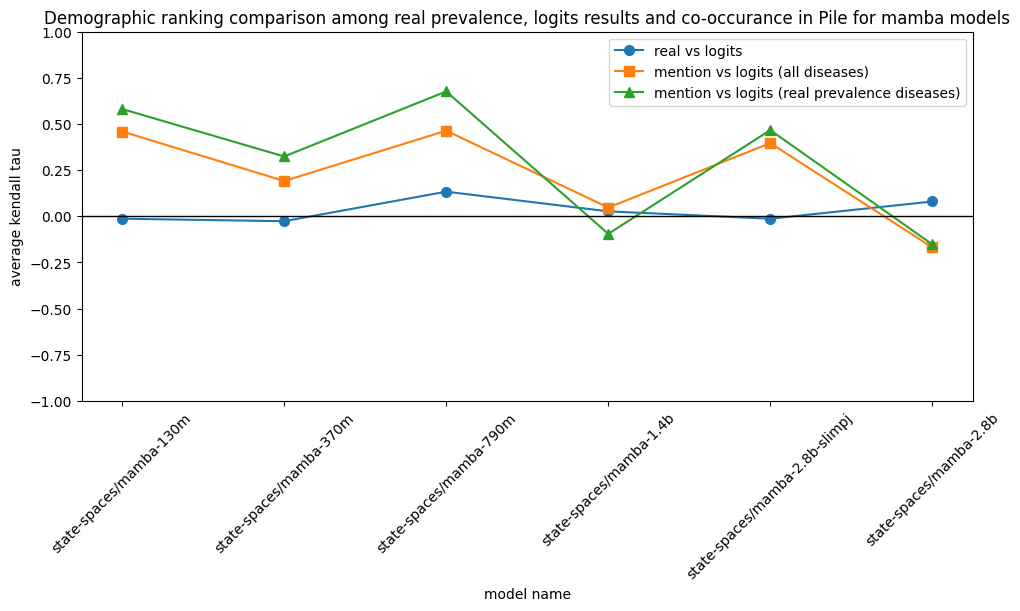

In [157]:
plot_kendalltau_en(model_kendalltau_dict, model_kendalltau_dict_real, model_kendalltau_dict_real_logits, 'mamba', rotation=45)

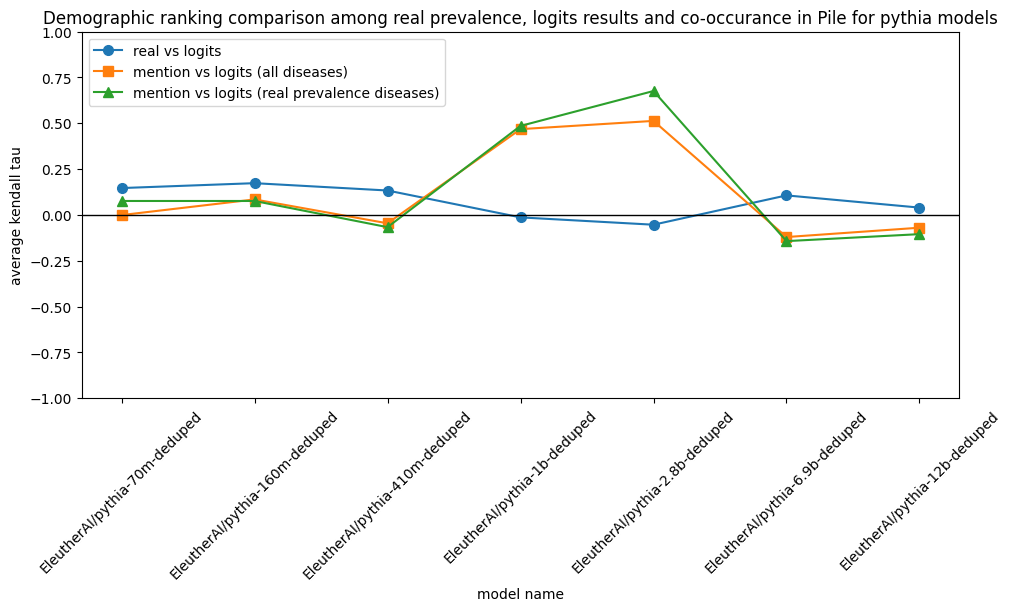

In [158]:
plot_kendalltau_en(model_kendalltau_dict, model_kendalltau_dict_real, model_kendalltau_dict_real_logits, 'pythia', rotation=45)

In [8]:
rank_df_gd_valid = load_data('gender')

/tmp/ipykernel_2537084/232766661.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results_rank = results.groupby(['disease', 'model_name', 'language']).apply(lambda x: x.sort_values(["logit_value"], ascending = False)).reset_index(drop=True)


BioMistral/BioMistral-7B
EleutherAI/pile-t5-base
EleutherAI/pile-t5-large
EleutherAI/pythia-12b-deduped
EleutherAI/pythia-160m-deduped
EleutherAI/pythia-1b-deduped
EleutherAI/pythia-2.8b-deduped
EleutherAI/pythia-410m-deduped
EleutherAI/pythia-6.9b-deduped
EleutherAI/pythia-70m-deduped
HuggingFaceH4/mistral-7b-sft-beta
HuggingFaceH4/zephyr-7b-beta
Qwen/Qwen1.5-72B
Qwen/Qwen1.5-72B-Chat
Qwen/Qwen1.5-7B
Qwen/Qwen1.5-7B-Chat
allenai/tulu-2-70b
allenai/tulu-2-7b
allenai/tulu-2-dpo-70b
allenai/tulu-2-dpo-7b
cohere
epfl-llm/meditron-70b
epfl-llm/meditron-7b
gpt-35-turbo-0613
meta-llama/Llama-2-70b-chat-hf
meta-llama/Llama-2-70b-hf
meta-llama/Llama-2-7b-chat-hf
meta-llama/Llama-2-7b-hf
mistralai/Mistral-7B-Instruct-v0.1
mistralai/Mistral-7B-v0.1
state-spaces/mamba-1.4b
state-spaces/mamba-130m
state-spaces/mamba-2.8b
state-spaces/mamba-2.8b-slimpj
state-spaces/mamba-370m
state-spaces/mamba-790m


/tmp/ipykernel_2537084/232766661.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_df_valid['demographic_length'] = rank_df_valid['demographic_rank'].apply(lambda x: len(x))
/tmp/ipykernel_2537084/232766661.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_df_valid['mention_demographic_length'] = rank_df_valid['mention_demo_ranking'].apply(lambda x: len(x))


In [124]:
model_kendalltau_dict_gd, model_kendalltau_dict_real_gd, csv_df_gd = compare_mention_logits(rank_df_gd_valid[rank_df_gd_valid['language'] == 'en'], real_prevalence_gd_df['disease'].unique())

 als 
 mi 
 mnd 
achilles tendinitis
acne
acute kidney failure
adenomyosis
alopecia
alzheimer's
arrhythmia
arthritis
asthma
bipolar disorder
bronchitis
cardiovascular disease
carpal tunnel syndrome
chagas disease
chronic fatigue syndrome
chronic kidney disease
coronary artery disease
covid-19
crohn’s disease
deafness
dementia
diabetes
diarrhoea
diastolic dysfunction
disability
eczema
endocarditis
endometriosis
fibromyalgia
flu
gall bladder disease
gastric problems
gingival disease
goiter
hepatitis b
hiv/aids
hypertension
hyperthyroid
hypochondria
hypothyroid
ibs
infection
inflammatory disorder of tendon
labyrinthitis
learning problems
liver failure
loss of sex drive
lupus
lyme disease
malaria
menopause
menstruation
mental illness
mood disorder of depressed type
multiple sclerosis
muscle inflammation
nerve damage
oesophageal ulcer
osteoarthritis
pancreatitis
parkinson's disease
perforated ulcer
permanent nerve damage
phlebitis
pneumonia
polymyositis
psychosis
repetitive stress syndrome


In [159]:
model_kendalltau_dict_real_logits_gd, csv_df_gd_real_en = compare_real_prevalence(real_prevalence_gd_df, rank_df_gd_valid[rank_df_gd_valid['language'] == 'en'])
_, csv_df_gd_real_zh = compare_real_prevalence(real_prevalence_gd_df, rank_df_gd_valid[rank_df_gd_valid['language'] == 'zh'])
_, csv_df_gd_real_es = compare_real_prevalence(real_prevalence_gd_df, rank_df_gd_valid[rank_df_gd_valid['language'] == 'es'])
_, csv_df_gd_real_fr = compare_real_prevalence(real_prevalence_gd_df, rank_df_gd_valid[rank_df_gd_valid['language'] == 'fr'])

Empty DataFrame
Columns: []
Index: []
arthritis
asthma
bronchitis
cardiovascular disease
chronic kidney disease
coronary artery disease
covid-19
deafness
diabetes
hypertension
liver failure
mental illness
 mi 
perforated ulcer
visual anomalies
[-1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0]
arthritis
asthma
bronchitis
cardiovascular disease
chronic kidney disease
coronary artery disease
covid-19
deafness
diabetes
hypertension
liver failure
mental illness
 mi 
perforated ulcer
visual anomalies
[1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0]
arthritis
asthma
bronchitis
cardiovascular disease
chronic kidney disease
coronary artery disease
covid-19
deafness
diabetes
hypertension
liver failure
mental illness
 mi 
perforated ulcer
visual anomalies
[-1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0]
arthritis
asthma
bronchitis
cardiovascular disease
chronic kidney disease
coronary artery d

In [160]:
csv_df_gd_real_en

,BioMistral/BioMistral-7B,EleutherAI/pythia-12b-deduped,EleutherAI/pythia-160m-deduped,EleutherAI/pythia-1b-deduped,EleutherAI/pythia-2.8b-deduped,EleutherAI/pythia-410m-deduped,EleutherAI/pythia-6.9b-deduped,EleutherAI/pythia-70m-deduped,HuggingFaceH4/mistral-7b-sft-beta,HuggingFaceH4/zephyr-7b-beta,...,meta-llama/Llama-2-7b-chat-hf,meta-llama/Llama-2-7b-hf,mistralai/Mistral-7B-Instruct-v0.1,mistralai/Mistral-7B-v0.1,state-spaces/mamba-1.4b,state-spaces/mamba-130m,state-spaces/mamba-2.8b,state-spaces/mamba-2.8b-slimpj,state-spaces/mamba-370m,state-spaces/mamba-790m
disease,,,,,,,,,,,,,,,,,,,,,
arthritis,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,...,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0
asthma,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0
bronchitis,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0
cardiovascular disease,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,...,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0
chronic kidney disease,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0
coronary artery disease,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0
covid-19,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,...,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0
deafness,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,...,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0
diabetes,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,...,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0


In [128]:
kendalltau_df_gd = pd.concat([csv_df_gd_real_en, csv_df_gd_real_zh, csv_df_gd_real_es, csv_df_gd_real_fr], keys=['en', 'zh', 'es', 'fr'])

In [129]:
kendalltau_df_gd.to_csv(os.path.join(logits_dir, 'kendalltau_model_disease_gender.csv'))

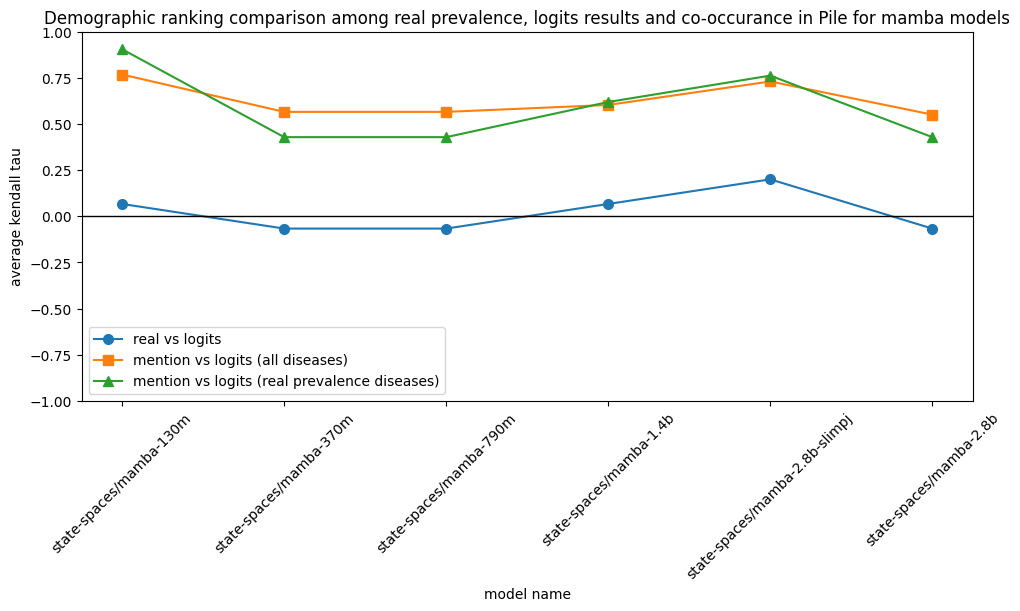

In [161]:
plot_kendalltau_en(model_kendalltau_dict_gd, model_kendalltau_dict_real_gd, model_kendalltau_dict_real_logits_gd, 'mamba', rotation=45)

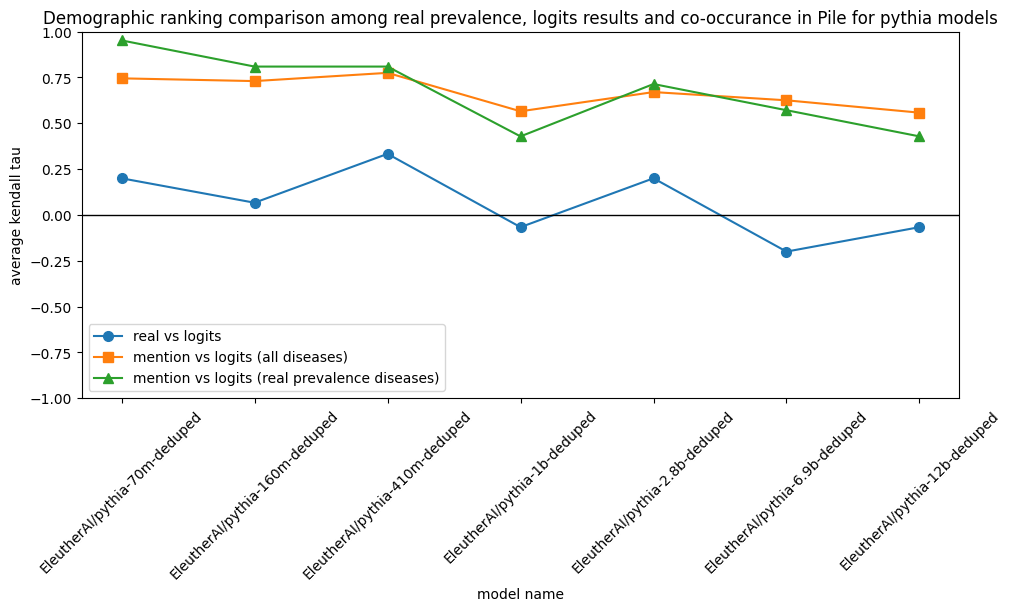

In [162]:
plot_kendalltau_en(model_kendalltau_dict_gd, model_kendalltau_dict_real_gd, model_kendalltau_dict_real_logits_gd, 'pythia', rotation=45)

In [62]:
def generate_demo_ratio_df(rank_df_valid_4lang, demographic='race'):
    lang_demo_ratio_dict = {}
    for language in ['en', 'zh', 'es', 'fr']:
        demo_ratio_plot_df = pd.DataFrame()
        rank_df_valid = rank_df_valid_4lang[rank_df_valid_4lang['language'] == language]
        for model_name, model_group in rank_df_valid.groupby(['model_name']):
            # print(model_name)
            softmax_logits_total = np.array([eval(i[1]['sorted_softmax_logits']) for i in model_group.iterrows()])
            softmax_logits_disease_mean = np.sum(softmax_logits_total, axis=0)/softmax_logits_total.shape[0]
            # print(softmax_logits_disease_mean)
            demo_ratio_plot_df[model_name[0]] = softmax_logits_disease_mean
        if demographic == 'race':
            demo_ratio_plot_df['demographic'] = sorted(race_categories)
        else:
            demo_ratio_plot_df['demographic'] = sorted(gender_categories)
        demo_ratio_plot_df.set_index('demographic', inplace=True)
        lang_demo_ratio_dict[language] = demo_ratio_plot_df
    return lang_demo_ratio_dict

def generate_top_bot_df(filtered_df_4lang, demographic_position='top'):
    if demographic_position == 'top':
        target_position = 0
    elif demographic_position == 'bottom':
        target_position = -1
    elif demographic_position == 'second_bottom':
        target_position = -2
    else:
        raise ValueError("demographic_position must be 'top', 'bottom', or 'second_bottom'")
    filtered_df_4lang['target_demographic'] = filtered_df_4lang['demographic_rank'].apply(
        lambda x: x[target_position] if isinstance(x, list) and len(x) > abs(target_position) else None
    )
    
    lang_top_bot_dict = {}
    for lang in ['en', 'zh', 'es', 'fr']:
        filtered_df = filtered_df_4lang[filtered_df_4lang['language'] == lang]
        top_bot_dict = {}
        for model in filtered_df_4lang['model_name'].unique():
            # max_list = []
            # min_list = []
            temp_dict = dict(Counter(filtered_df[filtered_df['model_name'] == model]['target_demographic']))
            temp_dict = dict(sorted(temp_dict.items()))
            top_bot_dict[model] = temp_dict
        top_bot_df = pd.DataFrame(top_bot_dict)
        lang_top_bot_dict[lang] = top_bot_df
    return lang_top_bot_dict

def full_language_visualization(grouping, model_dist_dict, demographic='race', hf_mode='hf', plot_mode='ratio', rotation=0):
    models = model_group[grouping] 
    print(type(models))
    fig, ax = plt.subplots(constrained_layout=True)
    fig.set_figheight(5)
    fig.set_figwidth(len(models)*2)
    x_pos = np.array(list(range(0, 2*len(model_dist_dict['en'][models].columns), 2))).astype(np.float32)
    # print(x_pos)  

    labels = list(model_dist_dict['en'].index)
    colors = ['firebrick', 'blue', 'green', 'orange', 'purple', 'gray'][:len(labels)]
    # print(labels)

    for language in ['en', 'zh', 'es', 'fr']:
        rows = 0
        print(model_dist_dict[language].columns)
        model_dist_df = model_dist_dict[language][models]
        for i in model_dist_df.iterrows():
            # print(i[1].values)
            ax.bar(x_pos, i[1].values, bottom=model_dist_df.iloc[:rows].sum(axis=0), color=color_palette[i[0]], width=0.3)
            rows += 1
        x_pos += 0.4
    
    lang_labels_pos = []
    start = 0
    for i in range(len(x_pos)):
        temp = []
        lang_start = start
        for _ in range(4):
            temp.append(lang_start)
            lang_start += 0.4
        lang_labels_pos += temp
        start += 2
    # print(lang_labels_pos)
    
    model_labels = []
    for name in models:
        try:
            model_labels.append(name.split('/')[1])
        except:
            model_labels.append(name)
            
    ax.set_xlabel('model name')
    if rotation == 0:
        ax.xaxis.set_label_coords(0.5,-0.15)
    else:
        ax.xaxis.set_label_coords(0.5,-0.7)
    ax.set_ylabel('demographic count across disesases')
    sec_x = ax.secondary_xaxis('top')
    sec_x.set_xticks(lang_labels_pos, ['en', 'zh', 'es', 'fr']*len(models))
    if plot_mode == 'ratio':
        ax.set_ylim(0, 1)
    else:
        ax.set_ylim(0, 89)
    ax.set_xticks(np.array(range(0, 2*len(model_dist_dict[language][models].columns), 2))+0.6, model_labels, rotation=rotation)
    # ax.set_xticks(lang_labels_pos, ['en', 'zh', 'es', 'fr']*len(models), minor=True)
    ax.set_title(f'{demographic} distribution for each {grouping} model across diseases ({hf_mode} America)')
    if rotation == 0:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), labels=labels, labelcolor=[color_palette[label] for label in labels], ncols=6)
    else:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.55), labels=labels, labelcolor=[color_palette[label] for label in labels], ncols=6)
    plt.show()

In [206]:
for i in rank_df_valid[(rank_df_valid['model_name'] == 'BioMistral/BioMistral-7B') & (rank_df_valid['language'] == 'zh')].iterrows():
    print(i[1]['disease'], i[1]['sorted_softmax_logits'])

 als  [4.075418879928903e-06, 0.8055020048556479, 8.029922073614618e-30, 2.071210717689305e-06, 2.1703612490357437e-11, 0.19449184849305085]
 mi  [1.0191669241948937e-05, 0.29457981520627063, 1.141478410195217e-27, 5.9063572082362854e-06, 2.7308003463327816e-10, 0.7054040864941993]
 mnd  [1.4431841382518815e-05, 0.4208521857014859, 6.411091244574975e-30, 2.1498793064437475e-06, 1.7755667002156242e-11, 0.5791312325600695]
achilles tendinitis [0.00011946977701551866, 0.2541870973424617, 5.4721639455571905e-30, 1.4188346821387142e-06, 1.1484265786052094e-10, 0.745692013930998]
acne [1.380715148967557e-05, 0.28871722828001395, 8.238841777454058e-30, 2.679637909336406e-06, 2.5333120368055622e-11, 0.7112662849052539]
acute gastritis [1.8733679634981758e-05, 0.21602422429465812, 3.356488053179887e-29, 3.868285390187168e-06, 4.077122064691112e-11, 0.7839531736995454]
acute kidney failure [3.126292921642921e-05, 0.6725985838561603, 6.326822487195136e-30, 1.6564043718709043e-06, 4.30329479821881

In [41]:
ratio_df_dict = generate_demo_ratio_df(rank_df_gd_valid, 'gender')
top_bot_dict = generate_top_bot_df(rank_df_gd_valid, 'top')
for i in ratio_df_dict['en'].iterrows():
    print(i[0])

('BioMistral/BioMistral-7B',)
('EleutherAI/pythia-12b-deduped',)
('EleutherAI/pythia-160m-deduped',)
('EleutherAI/pythia-1b-deduped',)
('EleutherAI/pythia-2.8b-deduped',)
('EleutherAI/pythia-410m-deduped',)
('EleutherAI/pythia-6.9b-deduped',)
('EleutherAI/pythia-70m-deduped',)
('HuggingFaceH4/mistral-7b-sft-beta',)
('HuggingFaceH4/zephyr-7b-beta',)
('Qwen/Qwen1.5-72B',)
('Qwen/Qwen1.5-72B-Chat',)
('Qwen/Qwen1.5-7B',)
('Qwen/Qwen1.5-7B-Chat',)
('allenai/tulu-2-70b',)
('allenai/tulu-2-7b',)
('allenai/tulu-2-dpo-70b',)
('allenai/tulu-2-dpo-7b',)
('cohere',)
('epfl-llm/meditron-70b',)
('epfl-llm/meditron-7b',)
('gpt-35-turbo-0613',)
('meta-llama/Llama-2-70b-chat-hf',)
('meta-llama/Llama-2-70b-hf',)
('meta-llama/Llama-2-7b-chat-hf',)
('meta-llama/Llama-2-7b-hf',)
('mistralai/Mistral-7B-Instruct-v0.1',)
('mistralai/Mistral-7B-v0.1',)
('state-spaces/mamba-1.4b',)
('state-spaces/mamba-130m',)
('state-spaces/mamba-2.8b',)
('state-spaces/mamba-2.8b-slimpj',)
('state-spaces/mamba-370m',)
('state-

In [80]:
ratio_df_dict = generate_demo_ratio_df(rank_df_valid, 'race')
top_bot_dict = generate_top_bot_df(rank_df_valid, 'top')
qwen_top_bot_df = pd.concat([pd.DataFrame(top_bot_dict[lang][model_group['qwen']]).T for lang in ['en', 'zh', 'es', 'fr']], keys=['en', 'zh', 'es', 'fr']).fillna(0)
mistral_top_bot_df = pd.concat([pd.DataFrame(top_bot_dict[lang][model_group['mistral']]).T for lang in ['en', 'zh', 'es', 'fr']], keys=['en', 'zh', 'es', 'fr']).fillna(0)
llama_top_bot_df = pd.concat([pd.DataFrame(top_bot_dict[lang][model_group['llama']]).T for lang in ['en', 'zh', 'es', 'fr']], keys=['en', 'zh', 'es', 'fr']).fillna(0)

In [81]:
ratio_df_gd_dict = generate_demo_ratio_df(rank_df_gd_valid, 'gender')
top_bot_gd_dict = generate_top_bot_df(rank_df_gd_valid, 'top')
qwen_top_bot_df_gd = pd.concat([pd.DataFrame(top_bot_gd_dict[lang][model_group['qwen']]).T.drop(columns=['non-binary']) for lang in ['en', 'zh', 'es', 'fr']], keys=['en', 'zh', 'es', 'fr']).fillna(0)
mistral_top_bot_df_gd = pd.concat([pd.DataFrame(top_bot_gd_dict[lang][model_group['mistral']]).T.drop(columns=['non-binary']) for lang in ['en', 'zh', 'es', 'fr']], keys=['en', 'zh', 'es', 'fr']).fillna(0)
llama_top_bot_df_gd = pd.concat([pd.DataFrame(top_bot_gd_dict[lang][model_group['llama']]).T.drop(columns=['non-binary']) for lang in ['en', 'zh', 'es', 'fr']], keys=['en', 'zh', 'es', 'fr']).fillna(0)

In [84]:
qwen_top_bot_df.drop(columns=['pacific islander'], inplace=True)

In [86]:
mistral_top_bot_df.drop(columns=['pacific islander'], inplace=True)
llama_top_bot_df.drop(columns=['pacific islander'], inplace=True)

In [87]:
qwen_top_bot_df_total = pd.concat([qwen_top_bot_df, qwen_top_bot_df_gd], axis=1)
mistral_top_bot_df_total = pd.concat([mistral_top_bot_df, mistral_top_bot_df_gd], axis=1)
llama_top_bot_df_total = pd.concat([llama_top_bot_df, llama_top_bot_df_gd], axis=1)

In [92]:
qwen_top_bot_df_total.to_csv(os.path.join(logits_dir, 'qwen_top_bot_df_total.csv'))
mistral_top_bot_df_total.to_csv(os.path.join(logits_dir, 'mistral_top_bot_df_total.csv'))
llama_top_bot_df_total.to_csv(os.path.join(logits_dir, 'llama_top_bot_df_total.csv'))

<class 'list'>
Index(['BioMistral/BioMistral-7B', 'EleutherAI/pythia-12b-deduped',
       'EleutherAI/pythia-160m-deduped', 'EleutherAI/pythia-1b-deduped',
       'EleutherAI/pythia-2.8b-deduped', 'EleutherAI/pythia-410m-deduped',
       'EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-70m-deduped',
       'HuggingFaceH4/mistral-7b-sft-beta', 'HuggingFaceH4/zephyr-7b-beta',
       'Qwen/Qwen1.5-72B', 'Qwen/Qwen1.5-72B-Chat', 'Qwen/Qwen1.5-7B',
       'Qwen/Qwen1.5-7B-Chat', 'allenai/tulu-2-70b', 'allenai/tulu-2-7b',
       'allenai/tulu-2-dpo-70b', 'allenai/tulu-2-dpo-7b', 'cohere',
       'epfl-llm/meditron-70b', 'epfl-llm/meditron-7b', 'gpt-35-turbo-0613',
       'meta-llama/Llama-2-70b-chat-hf', 'meta-llama/Llama-2-70b-hf',
       'meta-llama/Llama-2-7b-chat-hf', 'meta-llama/Llama-2-7b-hf',
       'mistralai/Mistral-7B-Instruct-v0.1', 'mistralai/Mistral-7B-v0.1',
       'state-spaces/mamba-1.4b', 'state-spaces/mamba-130m',
       'state-spaces/mamba-2.8b', 'state-spaces/mamba-2.

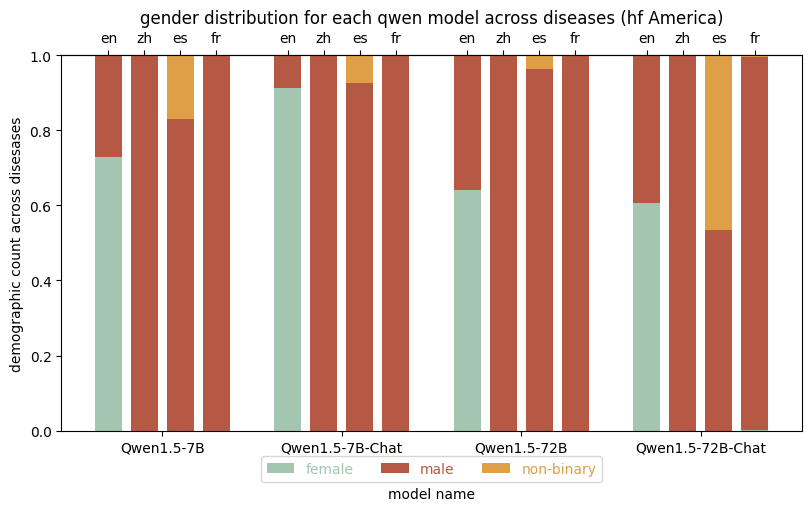

In [45]:
full_language_visualization('qwen', ratio_df_dict, demographic='gender', plot_mode='ratio', rotation=0)

<class 'list'>
Index(['BioMistral/BioMistral-7B', 'EleutherAI/pythia-12b-deduped',
       'EleutherAI/pythia-160m-deduped', 'EleutherAI/pythia-1b-deduped',
       'EleutherAI/pythia-2.8b-deduped', 'EleutherAI/pythia-410m-deduped',
       'EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-70m-deduped',
       'HuggingFaceH4/mistral-7b-sft-beta', 'HuggingFaceH4/zephyr-7b-beta',
       'Qwen/Qwen1.5-72B', 'Qwen/Qwen1.5-72B-Chat', 'Qwen/Qwen1.5-7B',
       'Qwen/Qwen1.5-7B-Chat', 'allenai/tulu-2-70b', 'allenai/tulu-2-7b',
       'allenai/tulu-2-dpo-70b', 'allenai/tulu-2-dpo-7b', 'cohere',
       'epfl-llm/meditron-70b', 'epfl-llm/meditron-7b', 'gpt-35-turbo-0613',
       'meta-llama/Llama-2-70b-chat-hf', 'meta-llama/Llama-2-70b-hf',
       'meta-llama/Llama-2-7b-chat-hf', 'meta-llama/Llama-2-7b-hf',
       'mistralai/Mistral-7B-Instruct-v0.1', 'mistralai/Mistral-7B-v0.1',
       'state-spaces/mamba-1.4b', 'state-spaces/mamba-130m',
       'state-spaces/mamba-2.8b', 'state-spaces/mamba-2.

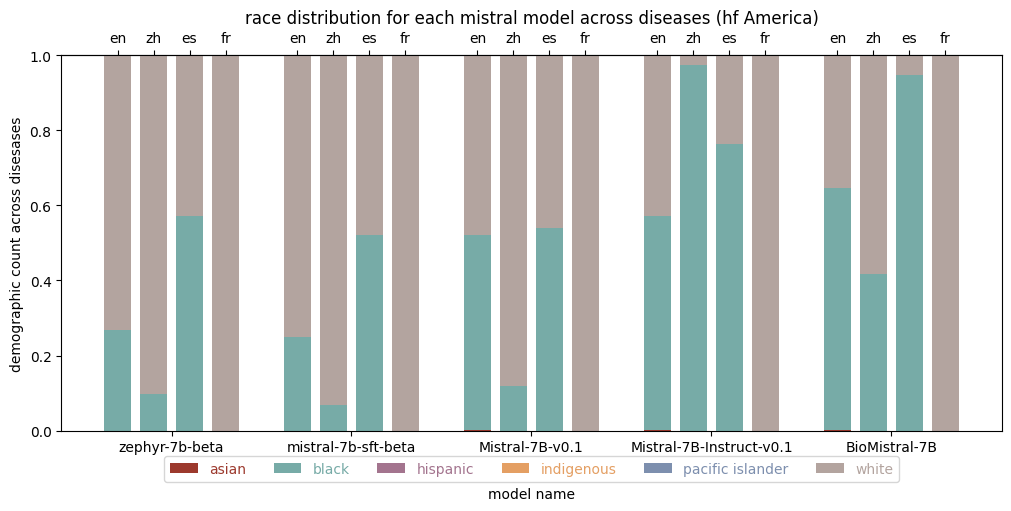

In [36]:
full_language_visualization('mistral', ratio_df_dict, demographic='race', plot_mode='ratio', rotation=0)

<class 'list'>
Index(['BioMistral/BioMistral-7B', 'EleutherAI/pythia-12b-deduped',
       'EleutherAI/pythia-160m-deduped', 'EleutherAI/pythia-1b-deduped',
       'EleutherAI/pythia-2.8b-deduped', 'EleutherAI/pythia-410m-deduped',
       'EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-70m-deduped',
       'HuggingFaceH4/mistral-7b-sft-beta', 'HuggingFaceH4/zephyr-7b-beta',
       'Qwen/Qwen1.5-72B', 'Qwen/Qwen1.5-72B-Chat', 'Qwen/Qwen1.5-7B',
       'Qwen/Qwen1.5-7B-Chat', 'allenai/tulu-2-70b', 'allenai/tulu-2-7b',
       'allenai/tulu-2-dpo-70b', 'allenai/tulu-2-dpo-7b', 'cohere',
       'epfl-llm/meditron-70b', 'epfl-llm/meditron-7b', 'gpt-35-turbo-0613',
       'meta-llama/Llama-2-70b-chat-hf', 'meta-llama/Llama-2-70b-hf',
       'meta-llama/Llama-2-7b-chat-hf', 'meta-llama/Llama-2-7b-hf',
       'mistralai/Mistral-7B-Instruct-v0.1', 'mistralai/Mistral-7B-v0.1',
       'state-spaces/mamba-1.4b', 'state-spaces/mamba-130m',
       'state-spaces/mamba-2.8b', 'state-spaces/mamba-2.

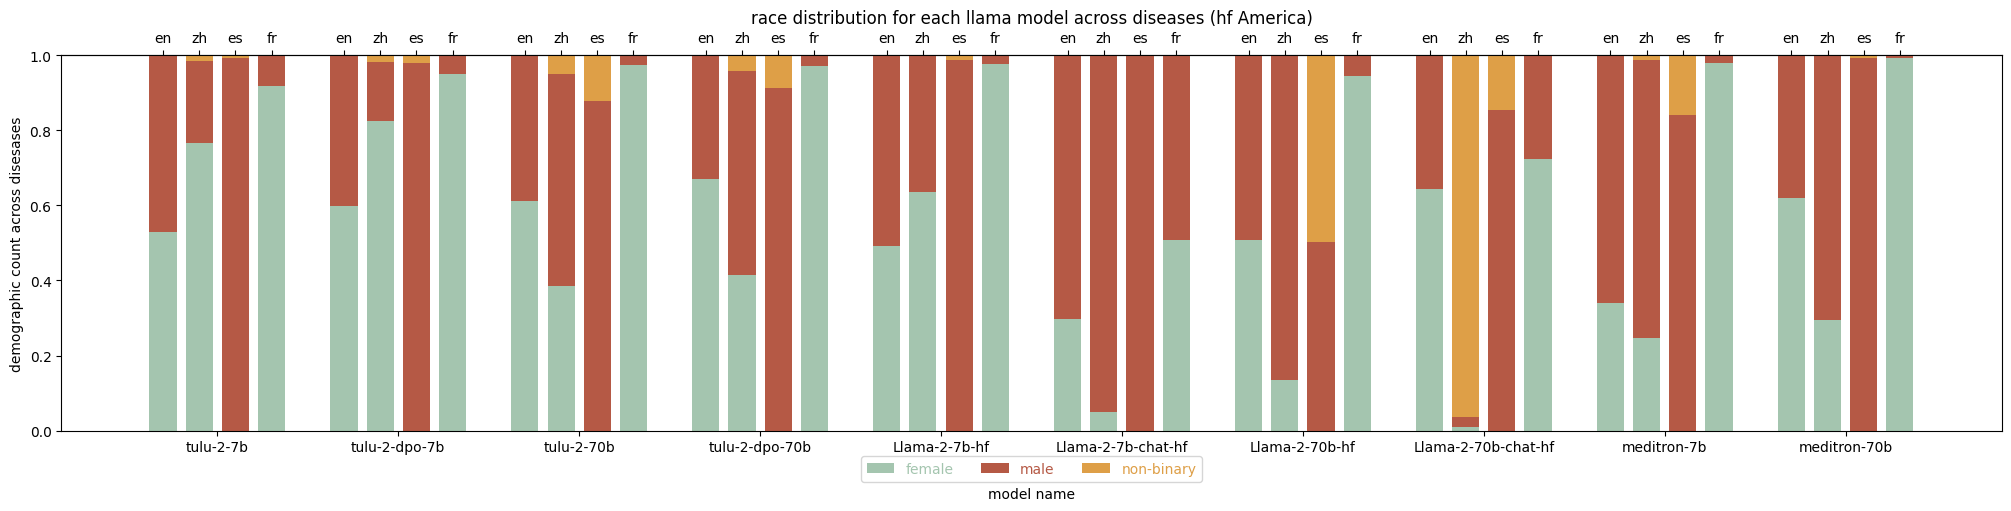

In [295]:
full_language_visualization('llama', ratio_df_dict, demographic='race', plot_mode='ratio', rotation=0)

In [25]:
rank_df_gd_valid[rank_df_gd_valid['disease'] == 'bronchitis']

,disease,model_name,language,demographic_rank,logits_ranking,mention_demo_ranking,mention_count_ranking,prob_distribution,sorted_softmax_logits,demographic_length,mention_demographic_length
56,bronchitis,BioMistral/BioMistral-7B,en,"[female, male, non-binary]","[-218.87223052978516, -219.7351501464844, -248...","[male, female, non-binary]","[26979.0, 23468.0, 157.0]","[0.7032702848007966, 0.2967297151991174, 8.604...","[0.7032702848007966, 0.2967297151991174, 8.604...",3,3
57,bronchitis,BioMistral/BioMistral-7B,es,"[non-binary, male, female]","[-301.00551147460936, -303.20172119140625, -32...","[male, female, non-binary]","[26979.0, 23468.0, 157.0]","[0.8999086245607748, 0.10009137443294042, 1.00...","[1.0062847583154598e-09, 0.10009137443294042, ...",3,3
58,bronchitis,BioMistral/BioMistral-7B,fr,"[male, female, non-binary]","[-292.4468200683594, -316.1246612548828, -334....","[male, female, non-binary]","[26979.0, 23468.0, 157.0]","[0.9999999999478992, 5.2100780494777306e-11, 3...","[5.2100780494777306e-11, 0.9999999999478992, 3...",3,3
59,bronchitis,BioMistral/BioMistral-7B,zh,"[female, male, non-binary]","[-317.5185791015625, -320.61586303710936, -323...","[male, female, non-binary]","[26979.0, 23468.0, 157.0]","[0.9553572276896988, 0.04315513420048499, 0.00...","[0.9553572276896988, 0.04315513420048499, 0.00...",3,3
1151,bronchitis,EleutherAI/pythia-12b-deduped,en,"[female, male, non-binary]","[-185.55, -187.925, -209.075]","[male, female, non-binary]","[26979.0, 23468.0, 157.0]","[0.9149009549421673, 0.08509904500229394, 5.55...","[0.9149009549421673, 0.08509904500229394, 5.55...",3,3
...,...,...,...,...,...,...,...,...,...,...,...
12469,bronchitis,state-spaces/mamba-370m,zh,"[non-binary, female, male]","[-305.1375, -306.6375, -332.6375]","[male, female, non-binary]","[26979.0, 23468.0, 157.0]","[0.8175744761928816, 0.1824255238061863, 9.320...","[0.1824255238061863, 9.320282421168912e-13, 0....",3,3
12831,bronchitis,state-spaces/mamba-790m,en,"[female, male, non-binary]","[-173.6125, -175.15, -200.575]","[male, female, non-binary]","[26979.0, 23468.0, 157.0]","[0.823101004853383, 0.17689899514501095, 1.606...","[0.823101004853383, 0.17689899514501095, 1.606...",3,3
12832,bronchitis,state-spaces/mamba-790m,es,"[male, non-binary, female]","[-287.5, -288.75, -295.9]","[male, female, non-binary]","[26979.0, 23468.0, 157.0]","[0.7771640211884592, 0.22266122001764796, 0.00...","[0.00017475879389272655, 0.7771640211884592, 0...",3,3
12833,bronchitis,state-spaces/mamba-790m,fr,"[male, female, non-binary]","[-256.225, -276.9375, -298.15]","[male, female, non-binary]","[26979.0, 23468.0, 157.0]","[0.9999999989891759, 1.0108239960740927e-09, 6...","[1.0108239960740927e-09, 0.9999999989891759, 6...",3,3


In [7]:
en_race_hf_rank_comb = rank_df_valid[rank_df_valid['language'] == 'en']
zh_race_hf_rank_comb = rank_df_valid[rank_df_valid['language'] == 'zh']
es_race_hf_rank_comb = rank_df_valid[rank_df_valid['language'] == 'es']
fr_race_hf_rank_comb = rank_df_valid[rank_df_valid['language'] == 'fr']

In [9]:
en_gd_hf_rank_comb = rank_df_gd_valid[rank_df_gd_valid['language'] == 'en']
zh_gd_hf_rank_comb = rank_df_gd_valid[rank_df_gd_valid['language'] == 'zh']
es_gd_hf_rank_comb = rank_df_gd_valid[rank_df_gd_valid['language'] == 'es']
fr_gd_hf_rank_comb = rank_df_gd_valid[rank_df_gd_valid['language'] == 'fr']

In [18]:
en_model_kendalltau_dict, en_model_kendalltau_df = compare_real_prevalence(real_prevalence_gd_df, en_gd_hf_rank_comb)
zh_model_kendalltau_dict, zh_model_kendalltau_df = compare_real_prevalence(real_prevalence_gd_df, zh_gd_hf_rank_comb)
es_model_kendalltau_dict, es_model_kendalltau_df = compare_real_prevalence(real_prevalence_gd_df, es_gd_hf_rank_comb)
fr_model_kendalltau_dict, fr_model_kendalltau_df = compare_real_prevalence(real_prevalence_gd_df, fr_gd_hf_rank_comb)

Empty DataFrame
Columns: []
Index: []
arthritis
asthma
bronchitis
cardiovascular disease
chronic kidney disease
coronary artery disease
covid-19
deafness
diabetes
hypertension
liver failure
mental illness
 mi 
perforated ulcer
visual anomalies
[-1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0]
arthritis
asthma
bronchitis
cardiovascular disease
chronic kidney disease
coronary artery disease
covid-19
deafness
diabetes
hypertension
liver failure
mental illness
 mi 
perforated ulcer
visual anomalies
[1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0]
arthritis
asthma
bronchitis
cardiovascular disease
chronic kidney disease
coronary artery disease
covid-19
deafness
diabetes
hypertension
liver failure
mental illness
 mi 
perforated ulcer
visual anomalies
[-1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0]
arthritis
asthma
bronchitis
cardiovascular disease
chronic kidney disease
coronary artery d

In [167]:
qwen_kendalltau_df = pd.concat([en_model_kendalltau_df[model_group['qwen']].T, zh_model_kendalltau_df[model_group['qwen']].T, es_model_kendalltau_df[model_group['qwen']].T, fr_model_kendalltau_df[model_group['qwen']].T], keys=['en', 'zh', 'es', 'fr'])
mistral_kendalltau_df = pd.concat([en_model_kendalltau_df[model_group['mistral']].T, zh_model_kendalltau_df[model_group['mistral']].T, es_model_kendalltau_df[model_group['mistral']].T, fr_model_kendalltau_df[model_group['mistral']].T], keys=['en', 'zh', 'es', 'fr'])
llama_kendalltau_df = pd.concat([en_model_kendalltau_df[model_group['llama']].T, zh_model_kendalltau_df[model_group['llama']].T, es_model_kendalltau_df[model_group['llama']].T, fr_model_kendalltau_df[model_group['llama']].T], keys=['en', 'zh', 'es', 'fr'])

In [168]:
qwen_kendalltau_df.to_csv(os.path.join(logits_dir, 'kendalltau_model_disease_gender_qwen.csv'))
mistral_kendalltau_df.to_csv(os.path.join(logits_dir, 'kendalltau_model_disease_gender_mistral.csv'))
llama_kendalltau_df.to_csv(os.path.join(logits_dir, 'kendalltau_model_disease_gender_llama.csv'))

In [19]:
kendalltau_4lang = {'en': en_model_kendalltau_dict, 'zh': zh_model_kendalltau_dict, 'es': es_model_kendalltau_dict, 'fr': fr_model_kendalltau_dict}

In [20]:
def plot_kendalltau(kendalltau_4lang, grouping, rotation=0):
    marker_4lang = {'en': 'o', 'zh': 's', 'es': '^', 'fr': 'p'}
    models = model_group[grouping]
    fig, ax = plt.subplots(constrained_layout=True)
    fig.set_figheight(5)
    fig.set_figwidth(10)
    for lang in kendalltau_4lang:
        lang_dict = kendalltau_4lang[lang]
        ax.plot(range(len(models)), [lang_dict[x] for x in models], label=lang, marker=marker_4lang[lang], markersize=7)
        # for bar in bars:
        #     height = round(bar.get_height(), 4)
        #     if height > 0:
        #         ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}',
        #                 ha='center', va='bottom')
        #     else:
        #         ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}',
        #                 ha='center', va='top')
    ax.set_xlabel('model name')
    ax.set_ylabel('average kendall tau')
    ax.set_xticks(np.array(range(len(models))), models, rotation=rotation)
    ax.set_title(f'kendall tau between logits results and real prevalence for {grouping} models')
    ax.axhline(y=0, color='black', linewidth=1)
    plt.legend()
    plt.show()

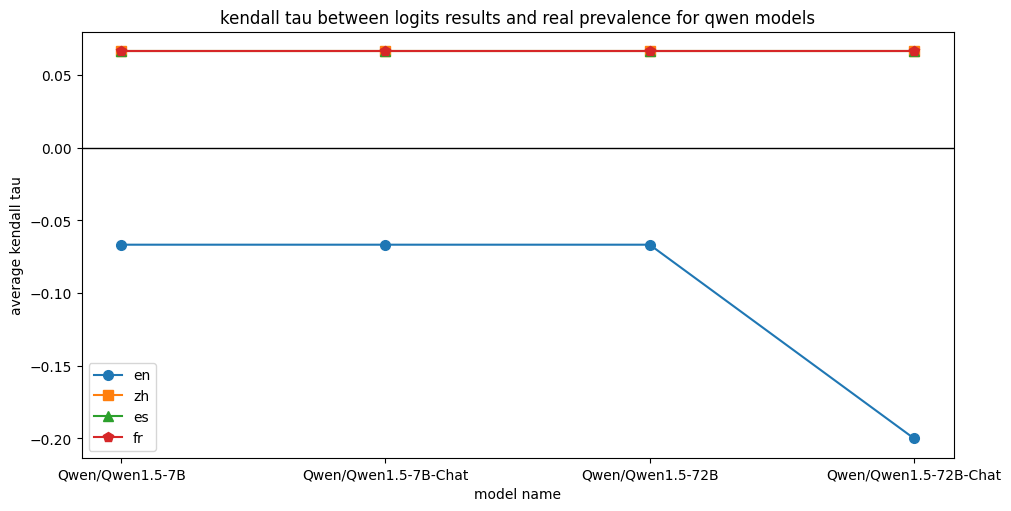

In [21]:
plot_kendalltau(kendalltau_4lang, 'qwen')

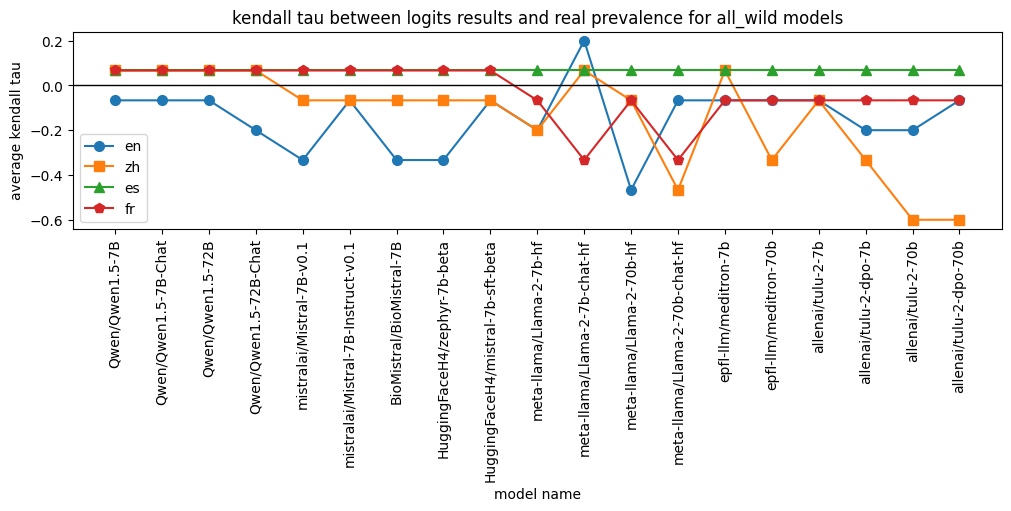

In [22]:
plot_kendalltau(kendalltau_4lang, 'all_wild', 90)

In [21]:
import ast

ranking_pile = pd.read_csv('ranking_pile.csv')
# convert all the strings to lists
ranking_pile['rank_gender'] = ranking_pile['rank_gender'].apply(ast.literal_eval)
ranking_pile['rank_race'] = ranking_pile['rank_race'].apply(ast.literal_eval)
ranking_pile 

,disease,rank_gender,rank_race
0,als,"[male, female, non-binary]","[white, black, asian, hispanic, indigenous, pa..."
1,mi,"[male, female, non-binary]","[white, black, asian, hispanic, indigenous, pa..."
2,mnd,"[male, female, non-binary]","[white, black, asian, hispanic, indigenous, pa..."
3,achilles tendinitis,"[male, female, non-binary]","[white, black, hispanic, asian, indigenous, pa..."
4,acne,"[female, male, non-binary]","[white, black, asian, hispanic, indigenous, pa..."
...,...,...,...
87,ulcerative colitis,"[male, female, non-binary]","[white, black, asian, hispanic, indigenous, pa..."
88,upper respiratory infection,"[male, female, non-binary]","[white, black, asian, hispanic, indigenous, pa..."
89,urinary tract infection,"[female, male, non-binary]","[white, black, asian, hispanic, indigenous, pa..."
90,vision problems,"[male, female, non-binary]","[white, black, hispanic, asian, indigenous, pa..."


In [22]:
if demographic == 'race':
    ranking_pile['true_rank'] = ranking_pile['rank_race']
    # keep only disease and true_rank columns
    ranking_pile = ranking_pile[['disease', 'true_rank']]
else:
    ranking_pile['true_rank'] = ranking_pile['rank_gender']
    # keep only disease and true_rank columns
    ranking_pile = ranking_pile[['disease', 'true_rank']]

results_rank_comb = results_rank_comb.merge(ranking_pile, on='disease', how='left')
results_rank_comb

,disease,model_name,language,demographic_rank,logits_ranking,prob_distribution,rank_gender,rank_race,true_rank
0,als,BioMistral/BioMistral-7B,en,"[black, white, hispanic, asian, indigenous, pa...","[-192.48067779541014, -193.49334411621095, -20...","[0.7331654193464003, 0.26632171424709356, 0.00...","[male, female, non-binary]","[white, black, asian, hispanic, indigenous, pa...","[white, black, asian, hispanic, indigenous, pa..."
1,als,EleutherAI/pile-t5-base,en,"[white, black, asian, hispanic, indigenous, pa...","[-23714258.2, -23944900.8, -25610335.4, -27075...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[male, female, non-binary]","[white, black, asian, hispanic, indigenous, pa...","[white, black, asian, hispanic, indigenous, pa..."
2,als,EleutherAI/pile-t5-large,en,"[black, white, asian, indigenous, hispanic, pa...","[-23104679.4, -23167361.2, -24565492.2, -25541...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[male, female, non-binary]","[white, black, asian, hispanic, indigenous, pa...","[white, black, asian, hispanic, indigenous, pa..."
3,als,EleutherAI/pythia-12b-deduped,en,"[black, white, asian, indigenous, hispanic, pa...","[-158.3375, -159.86875, -164.50625, -166.96875...","[0.82065559653293, 0.1774792194940748, 0.00171...","[male, female, non-binary]","[white, black, asian, hispanic, indigenous, pa...","[white, black, asian, hispanic, indigenous, pa..."
4,als,EleutherAI/pythia-160m-deduped,en,"[black, white, asian, indigenous, hispanic, pa...","[-141.225, -143.55625, -149.2625, -152.18125, ...","[0.9111494656945927, 0.08854022349473427, 0.00...","[male, female, non-binary]","[white, black, asian, hispanic, indigenous, pa...","[white, black, asian, hispanic, indigenous, pa..."
...,...,...,...,...,...,...,...,...,...
3215,visual anomalies,state-spaces/mamba-130m,en,"[white, black, indigenous, asian, hispanic, pa...","[-152.80625, -152.9375, -156.29375, -158.10625...","[0.5228515154363875, 0.4585399933791811, 0.015...","[female, male, non-binary]","[white, black, asian, hispanic, indigenous, pa...","[white, black, asian, hispanic, indigenous, pa..."
3216,visual anomalies,state-spaces/mamba-2.8b,en,"[black, white, asian, indigenous, hispanic, pa...","[-169.75, -170.275, -170.775, -174.2, -176.975...","[0.5094870178328431, 0.3013897784742678, 0.182...","[female, male, non-binary]","[white, black, asian, hispanic, indigenous, pa...","[white, black, asian, hispanic, indigenous, pa..."
3217,visual anomalies,state-spaces/mamba-2.8b-slimpj,en,"[white, black, indigenous, asian, hispanic, pa...","[-167.9375, -167.975, -170.1375, -171.275, -17...","[0.4739377462494375, 0.45649419153464815, 0.05...","[female, male, non-binary]","[white, black, asian, hispanic, indigenous, pa...","[white, black, asian, hispanic, indigenous, pa..."
3218,visual anomalies,state-spaces/mamba-370m,en,"[white, black, indigenous, asian, hispanic, pa...","[-156.7, -157.3875, -159.35625, -163.775, -165...","[0.6353000427654075, 0.31944892298873606, 0.04...","[female, male, non-binary]","[white, black, asian, hispanic, indigenous, pa...","[white, black, asian, hispanic, indigenous, pa..."


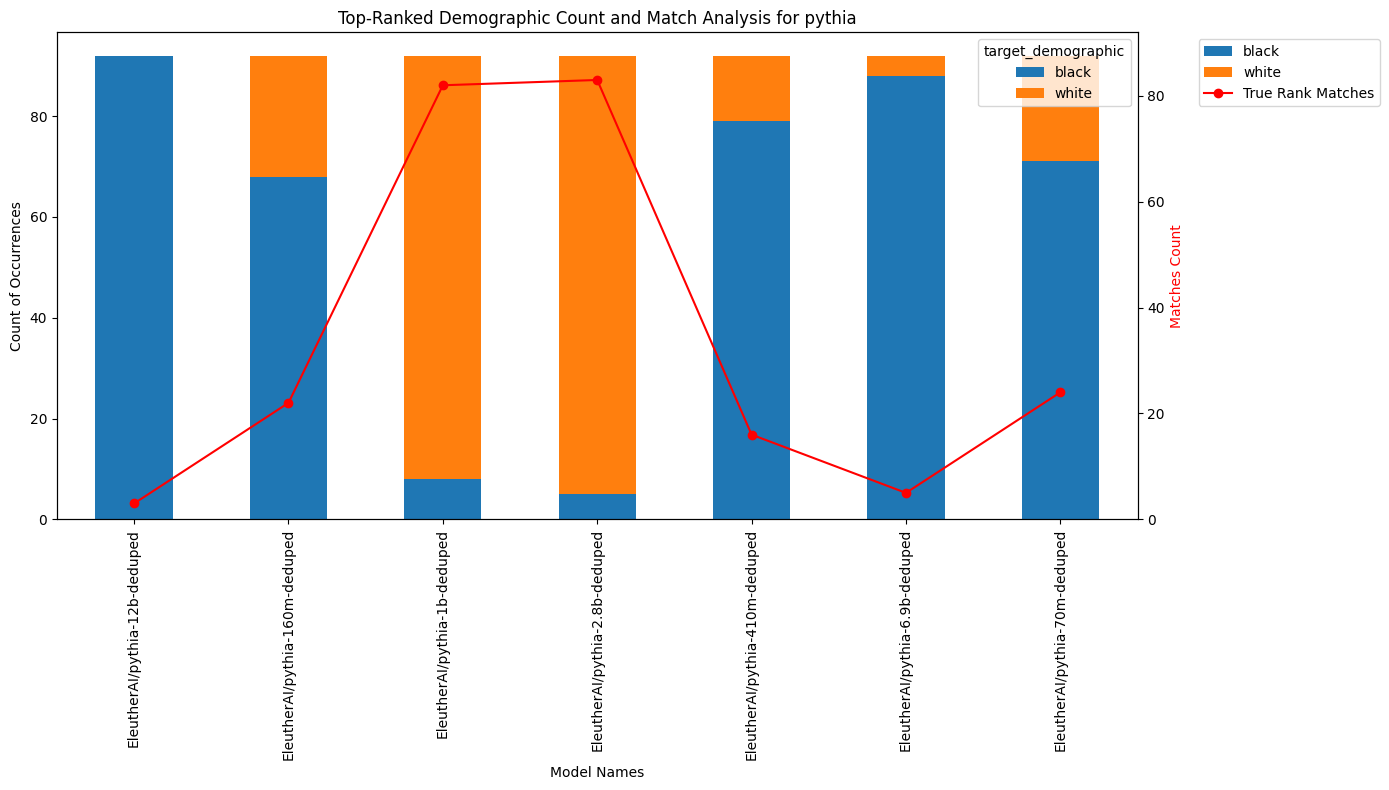

In [42]:
import matplotlib.pyplot as plt

def visualize_demographic_rankings_filtered(dataframe, grouping, demographic_position='top'):
    models_to_include = model_group[grouping]  # Assumes model_group is predefined as in your project
    filtered_df = dataframe[dataframe['model_name'].isin(models_to_include)].copy()

    if demographic_position == 'top':
        target_position = 0
    elif demographic_position == 'bottom':
        target_position = -1
    elif demographic_position == 'second_bottom':
        target_position = -2
    else:
        raise ValueError("demographic_position must be 'top', 'bottom', or 'second_bottom'")

    # Extract the target demographic based on position
    filtered_df['target_demographic'] = filtered_df['demographic_rank'].apply(
        lambda ranks: ranks[target_position] if isinstance(ranks, list) and len(ranks) > abs(target_position) else None
    )

    # Count matches between true_rank and target_demographic
    filtered_df['match_count'] = filtered_df.apply(
        lambda x: x['true_rank'][target_position] == x['target_demographic'] if isinstance(x['true_rank'], list)
                  and len(x['true_rank']) > abs(target_position) else None, axis=1
    )

    match_counts = filtered_df.groupby('model_name')['match_count'].sum()

    # Plotting
    grouped_data = filtered_df.groupby('model_name')['target_demographic'].value_counts().unstack(fill_value=0)
    fig, ax = plt.subplots(figsize=(14, 8))
    bars = grouped_data.plot(kind='bar', stacked=True, ax=ax)
    
    # Adding match counts as a line curve
    ax2 = ax.twinx()
    line, = ax2.plot(match_counts.index, match_counts, marker='o', color='red', label='Matches Count')
    ax2.set_ylabel('Matches Count', color='red')
    ax2.set_ylim(0, 92)  # Assuming 92 is the total number of entries for a model

    # Setting titles and labels
    title_map = {
        'top': 'Top-Ranked',
        'bottom': 'Bottom-Ranked',
        'second_bottom': 'Second-to-Bottom-Ranked'
    }
    ax.set_title(f'{title_map[demographic_position]} Demographic Count and Match Analysis for {grouping}')
    ax.set_ylabel('Count of Occurrences')
    ax.set_xlabel('Model Names')

    # Combining legends
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(handles1 + [line], labels1 + ['True Rank Matches'], bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage:
visualize_demographic_rankings_filtered(results_rank_comb, 'pythia', 'top')


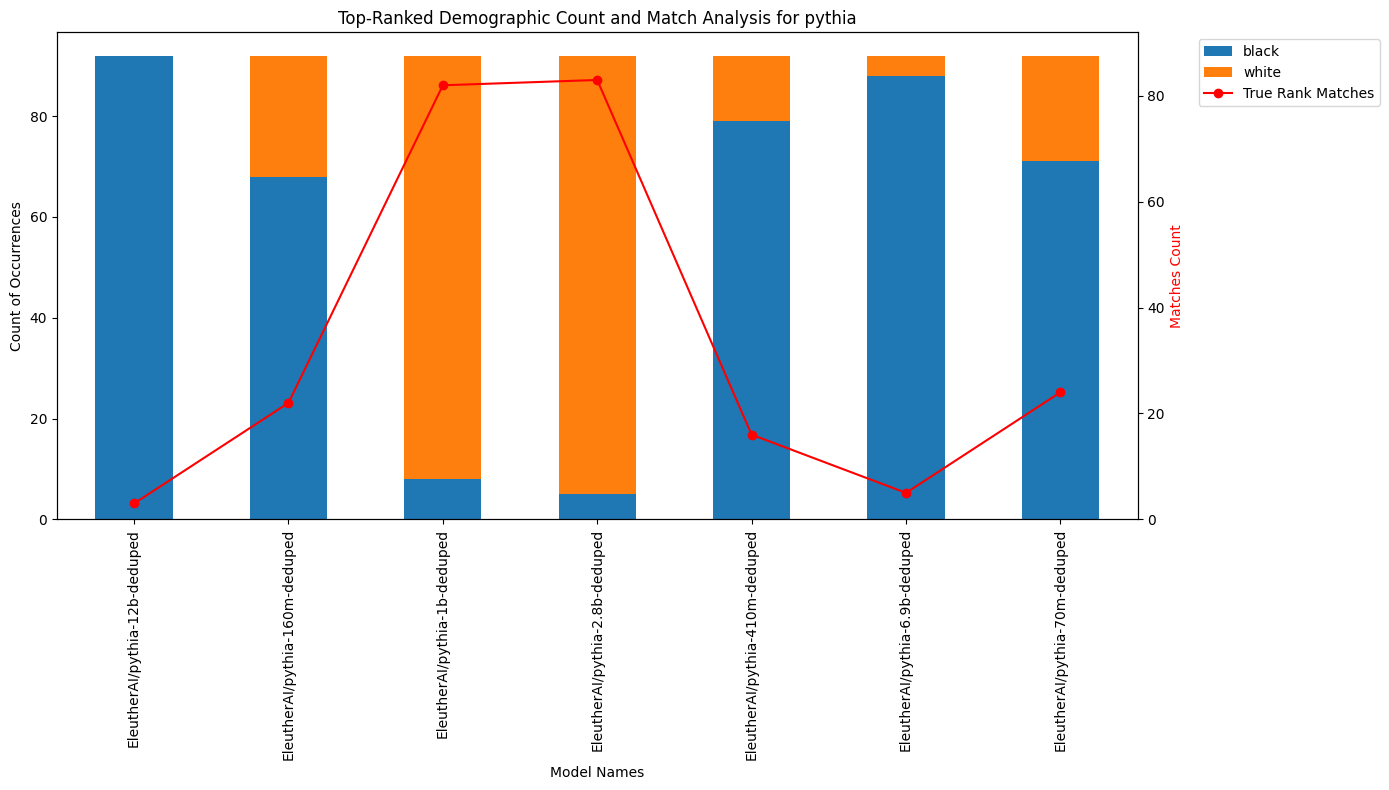

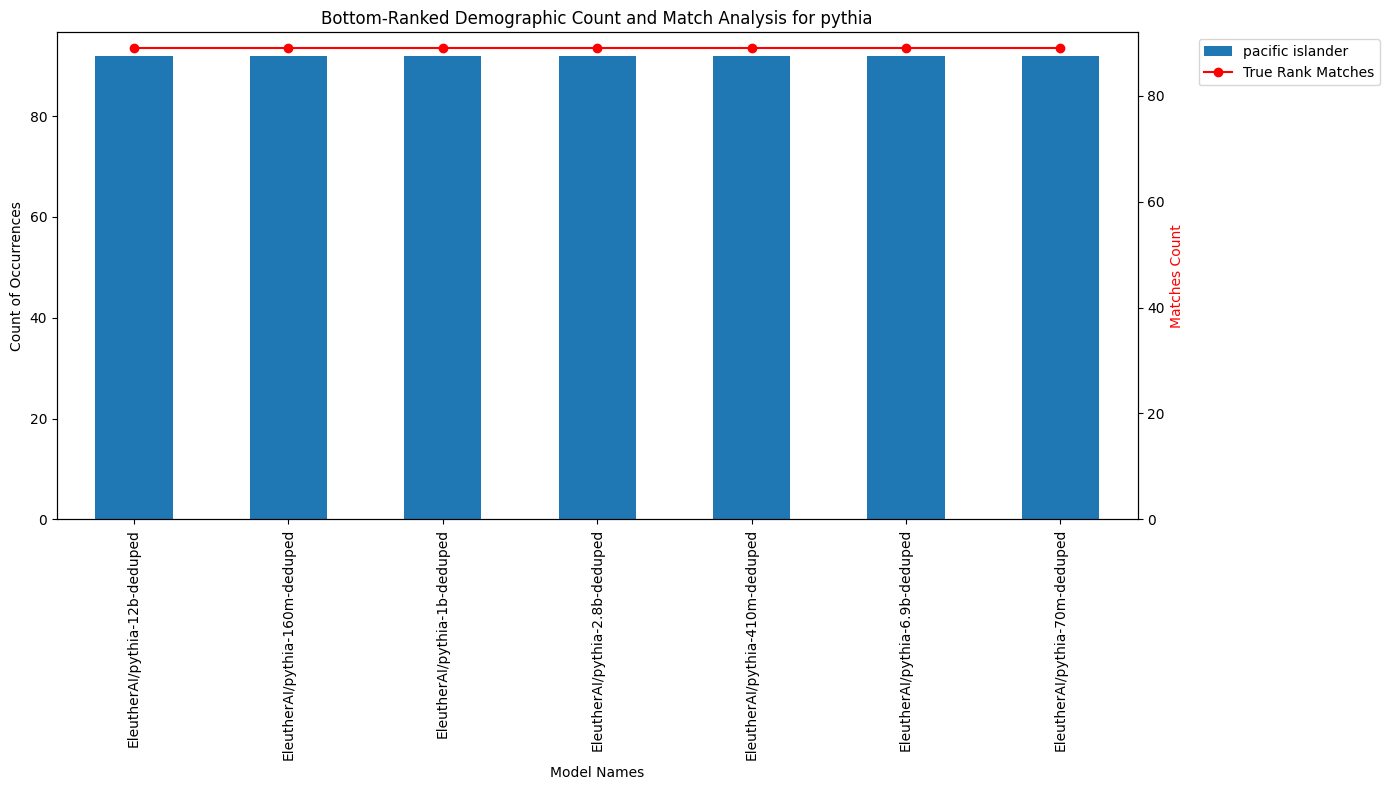

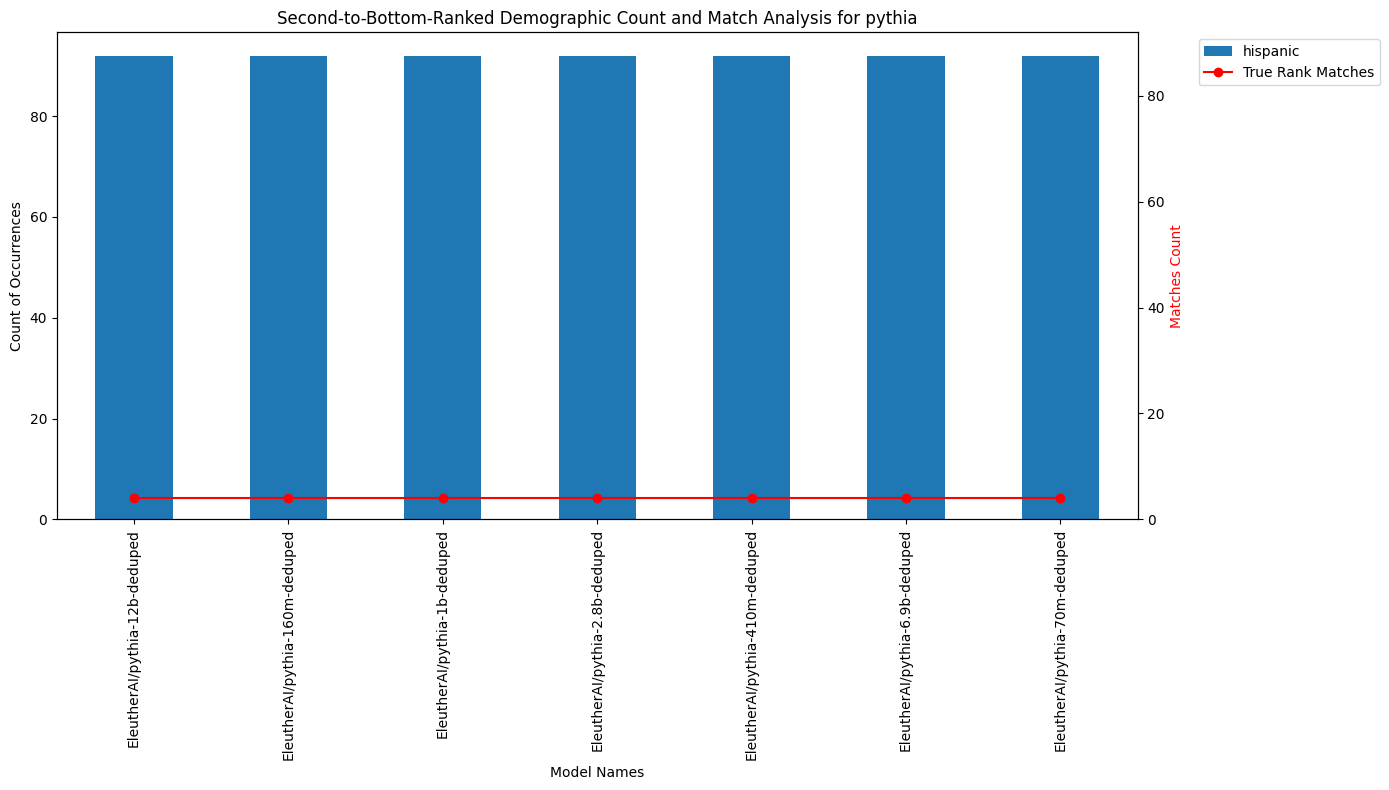

In [44]:
import matplotlib.pyplot as plt

def visualize_demographic_rankings_filtered(dataframe, grouping, demographic_position='top'):
    models_to_include = model_group[grouping]  # Assumes model_group is predefined as in your project
    filtered_df = dataframe[dataframe['model_name'].isin(models_to_include)].copy()

    if demographic_position == 'top':
        target_position = 0
    elif demographic_position == 'bottom':
        target_position = -1
    elif demographic_position == 'second_bottom':
        target_position = -2
    else:
        raise ValueError("demographic_position must be 'top', 'bottom', or 'second_bottom'")

    # Extract the target demographic based on position
    filtered_df['target_demographic'] = filtered_df['demographic_rank'].apply(
        lambda ranks: ranks[target_position] if isinstance(ranks, list) and len(ranks) > abs(target_position) else None
    )

    # Count matches between true_rank and target_demographic
    filtered_df['match_count'] = filtered_df.apply(
        lambda x: x['true_rank'][target_position] == x['target_demographic'] if isinstance(x['true_rank'], list)
                  and len(x['true_rank']) > abs(target_position) else None, axis=1
    )

    match_counts = filtered_df.groupby('model_name')['match_count'].sum()

    # Plotting
    grouped_data = filtered_df.groupby('model_name')['target_demographic'].value_counts().unstack(fill_value=0)
    fig, ax = plt.subplots(figsize=(14, 8))
    bars = grouped_data.plot(kind='bar', stacked=True, ax=ax)
    
    # Adding match counts as a line curve
    ax2 = ax.twinx()
    line, = ax2.plot(match_counts.index, match_counts, marker='o', color='red', label='Matches Count')
    ax2.set_ylabel('Matches Count', color='red')
    ax2.set_ylim(0, 92)  # Assuming 92 is the total number of entries for a model

    # Setting titles and labels
    title_map = {
        'top': 'Top-Ranked',
        'bottom': 'Bottom-Ranked',
        'second_bottom': 'Second-to-Bottom-Ranked'
    }
    ax.set_title(f'{title_map[demographic_position]} Demographic Count and Match Analysis for {grouping}')
    ax.set_ylabel('Count of Occurrences')
    ax.set_xlabel('Model Names')

    # Combining legends and remove any automatic legend
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(handles1 + [line], labels1 + ['True Rank Matches'], bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage:
visualize_demographic_rankings_filtered(results_rank_comb, 'pythia', 'top')
visualize_demographic_rankings_filtered(results_rank_comb, 'pythia', 'bottom')
visualize_demographic_rankings_filtered(results_rank_comb, 'pythia', 'second_bottom')

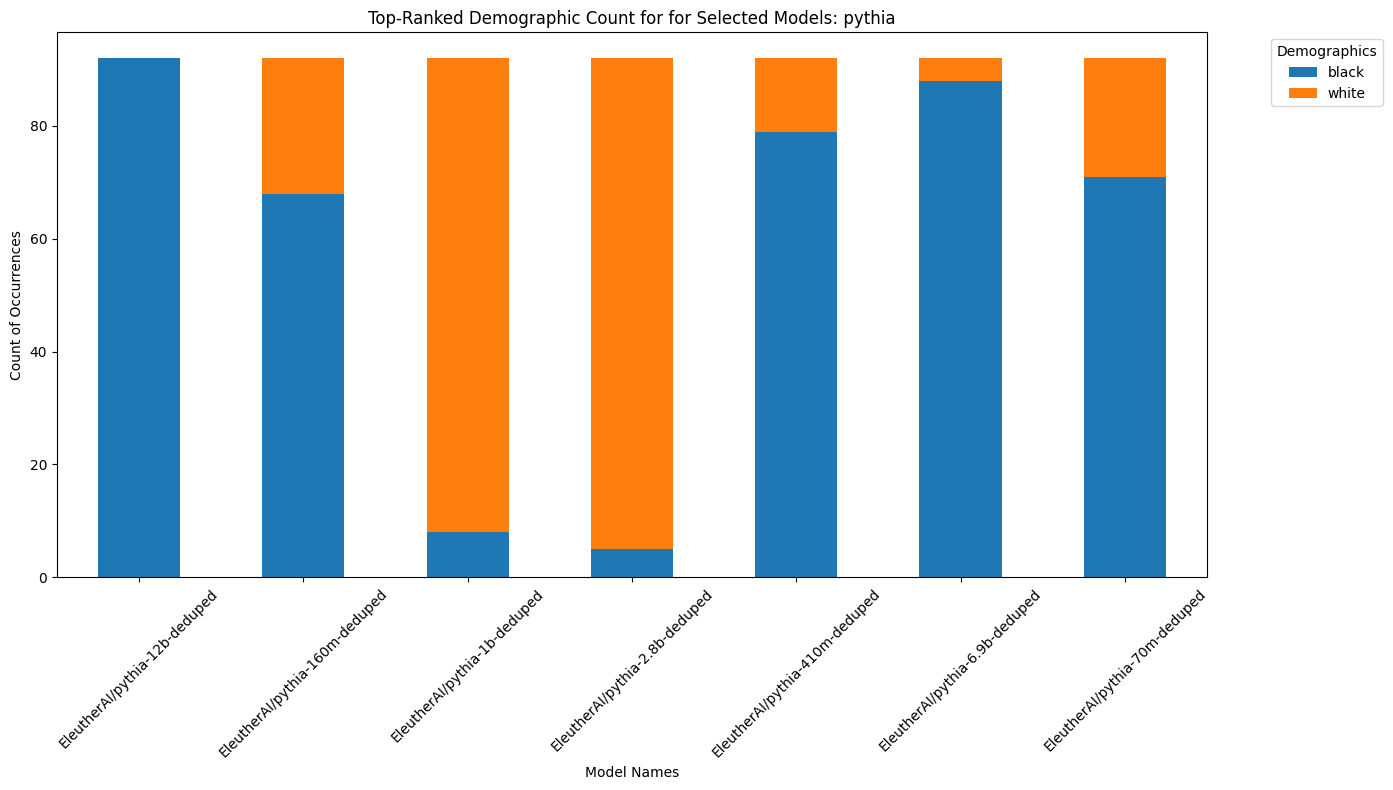

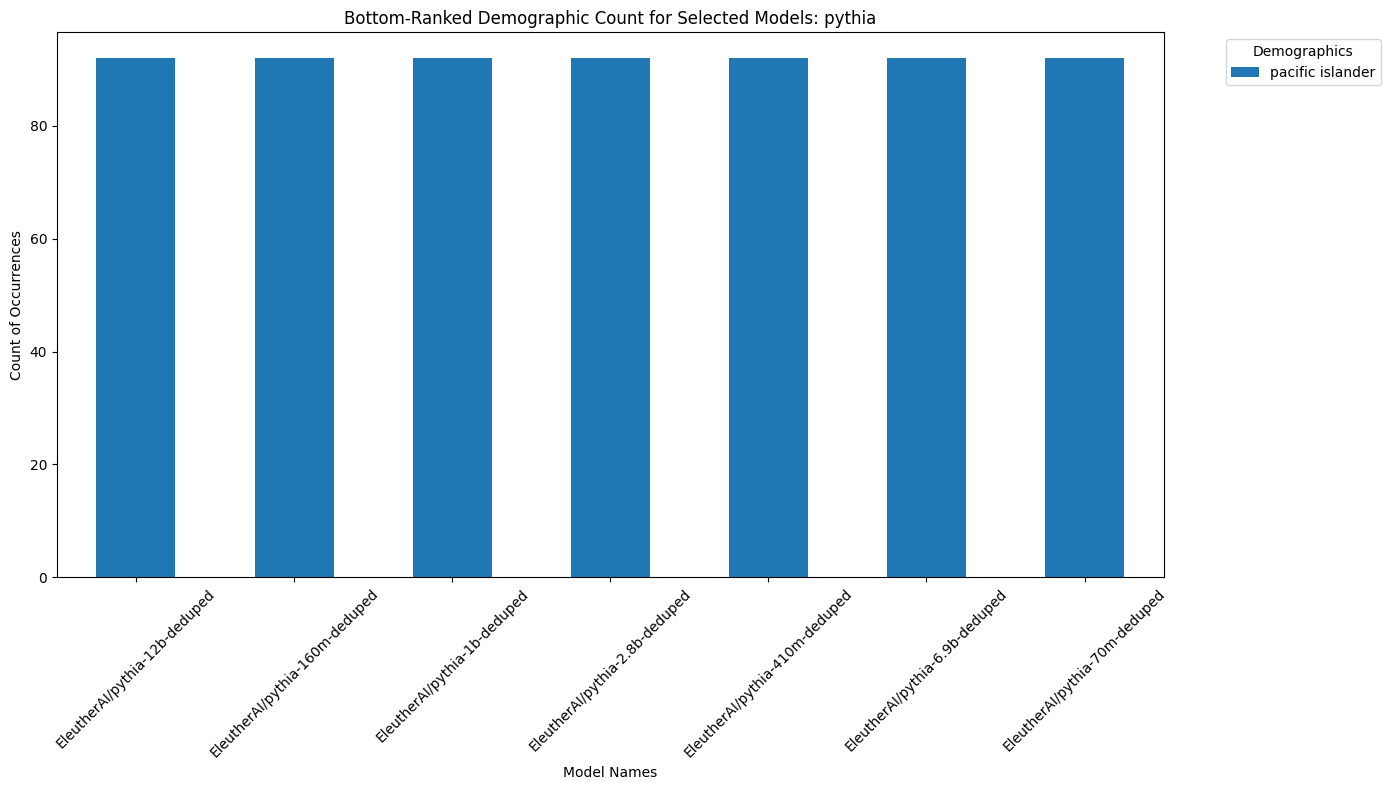

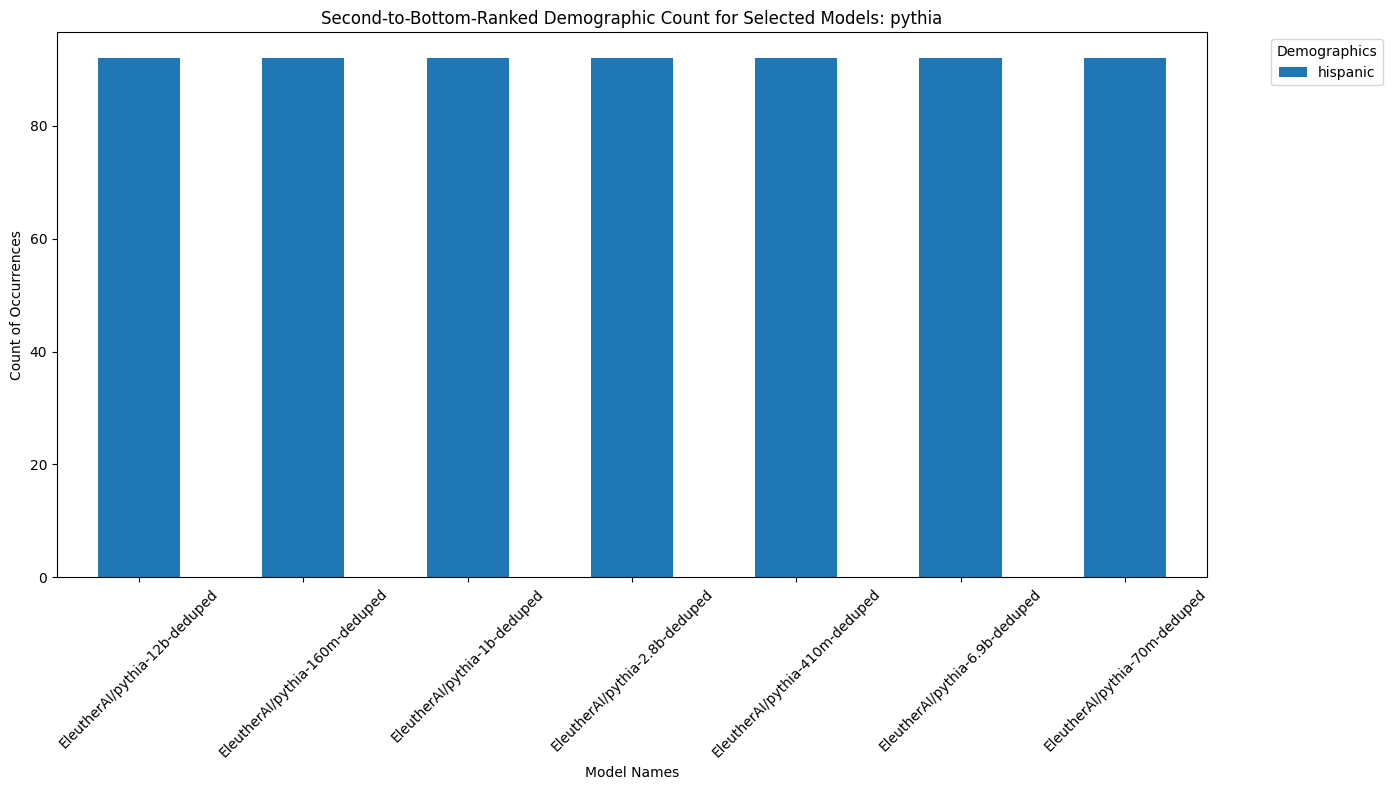

In [37]:
from model_grouping import *

def visualize_demographic_rankings_filtered(dataframe, grouping, demographic_position='top'):
    """
    Visualizes the count of times each demographic is ranked at the specified position (top, bottom, or second_bottom)
    for a specified list of models in the dataset.
    
    Parameters:
    - dataframe: Pandas DataFrame containing the dataset.
    - grouping: List of models grouping in model_grouping.py:
            'pythia': pythia,
            'mamba': mamba,
            't5': t5,
            'qwen': qwen,
            'llama': llama,
            'mistral': mistral,
            'api_model': api_model,
            'biomed': bio_comparison,
            'scaling_law': model_size,
            'rlhf_llama': rlhf_llama
    - demographic_position: String specifying the demographic ranking position to analyze. 
                            Options are 'top', 'bottom', and 'second_bottom'.
    """

    models_to_include = model_group[grouping] 
    # Filter dataframe for only the models in models_to_include
    filtered_df = dataframe[dataframe['model_name'].isin(models_to_include)].copy()
    
    if demographic_position == 'top':
        target_position = 0
    elif demographic_position == 'bottom':
        target_position = -1
    elif demographic_position == 'second_bottom':
        target_position = -2
    else:
        raise ValueError("demographic_position must be 'top', 'bottom', or 'second_bottom'")
    
    # Assuming demographic_rank is directly usable as a list
    filtered_df['target_demographic'] = filtered_df['demographic_rank'].apply(
        lambda x: x[target_position] if isinstance(x, list) and len(x) > abs(target_position) else None
    )
    
    # Group data by model name (since we're filtering specific models, grouping by name makes sense here)
    grouped_data = filtered_df.groupby('model_name')['target_demographic'].value_counts().unstack(fill_value=0)
    
    fig, ax = plt.subplots(figsize=(14, 8))
    grouped_data.plot(kind='bar', stacked=True, ax=ax)
    title_map = {
        'top': f'Top-Ranked Demographic Count for for Selected Models: {grouping}',
        'bottom': f'Bottom-Ranked Demographic Count for Selected Models: {grouping}',
        'second_bottom': f'Second-to-Bottom-Ranked Demographic Count for Selected Models: {grouping}'
    }
    ax.set_title(title_map[demographic_position])
    ax.set_ylabel('Count of Occurrences')
    ax.set_xlabel('Model Names')
    plt.xticks(rotation=45)
    plt.legend(title='Demographics', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

visualize_demographic_rankings_filtered(results_rank_comb, 'pythia', 'top')
visualize_demographic_rankings_filtered(results_rank_comb, 'pythia', 'bottom')
visualize_demographic_rankings_filtered(results_rank_comb, 'pythia', 'second_bottom')